# Home Credit Default Risk - <br><br> _First Looks at the Data_ <br> Investigation of Home Credit Application Features

__Module Imports and Graphics Runtime Configurations__

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from utils.feature_tools import boruta_feature_selection, correlation_threshold
from utils.plot import plot_correlation_matrix, plot_target_data
from utils.utils import reduce_mem_usage

In [2]:
sns.set_theme(context="notebook", style="white", palette="muted")
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False

In [3]:
pd.set_option("display.float_format", lambda x: f"{x:.5f}")

## Home Credit Application Data - Training Set <a class="anchor" id="section1"></a>

### Import Data <a class="anchor" id="section1_1"></a>

In [4]:
application_df = reduce_mem_usage(
    pd.read_csv("../data/original_data/application_train.csv")
)
print("Number of loan applications:", application_df.shape[0])
print("Number of features and target:", application_df.shape[1])
application_df

Memory usage before optimization: 286.23 MB


Optimizing columns: 100%|██████████| 122/122 [00:00<00:00, 277.32it/s]


Memory usage after optimization: 92.38 MB
Decreased by 67.7%
Number of loan applications: 307511
Number of features and target: 122


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00000,406597.50000,24700.50000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
1,100003,0,Cash loans,F,N,N,0,270000.00000,1293502.50000,35698.50000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,100004,0,Revolving loans,M,Y,Y,0,67500.00000,135000.00000,6750.00000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,100006,0,Cash loans,F,N,Y,0,135000.00000,312682.50000,29686.50000,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.00000,513000.00000,21865.50000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.00000,254700.00000,27558.00000,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.00000,269550.00000,12001.50000,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.00000,677664.00000,29979.00000,...,0,0,0,0,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000
307509,456254,1,Cash loans,F,N,Y,0,171000.00000,370107.00000,20205.00000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


### Train-Validation-Test Split

In [5]:
app_df = application_df.copy()
X = application_df.drop(columns=["TARGET"])
y = application_df["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.2, random_state=42
)

In [6]:
%store X_train
%store y_train
%store X_val
%store y_val
%store X_test
%store y_test

Stored 'X_train' (DataFrame)
Stored 'y_train' (Series)
Stored 'X_val' (DataFrame)
Stored 'y_val' (Series)
Stored 'X_test' (DataFrame)
Stored 'y_test' (Series)


### Target Data <a class="anchor" id="section1_2"></a>

There are 180918 applicants who could pay on time.
There are 15888 applicants with payment difficulties.


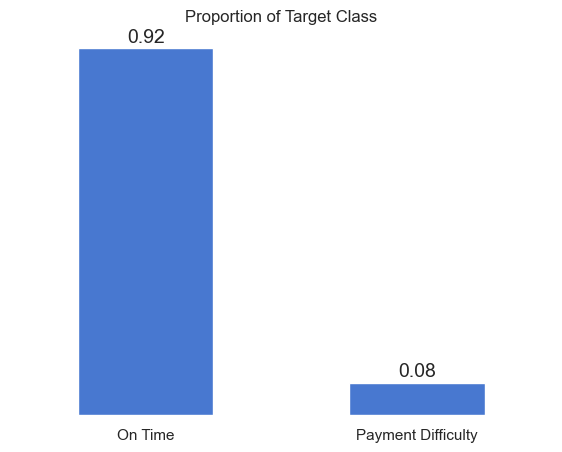

In [7]:
fig, ax = plot_target_data(y_train)

We can see that this data is quite imbalanced and this will need to be taken into account as we analyze it and develop models.

## Gaining Understanding About the Features

One issue with this dataset is that it is rather large and contains 122 features. In order to deal with this I have gone through a process of categorizing features based on similarities that I see in their descriptions and analyzing these sub-groups of features so as not to overwhelm myself with their plenitude. 

#### Application Info

These are features about the application itself.


In [8]:
application_feats = [
    "DAYS_ID_PUBLISH",
    "WEEKDAY_APPR_PROCESS_START",
    "HOUR_APPR_PROCESS_START",
    "FLAG_DOCUMENT_2",
    "FLAG_DOCUMENT_3",
    "FLAG_DOCUMENT_4",
    "FLAG_DOCUMENT_5",
    "FLAG_DOCUMENT_6",
    "FLAG_DOCUMENT_7",
    "FLAG_DOCUMENT_8",
    "FLAG_DOCUMENT_9",
    "FLAG_DOCUMENT_10",
    "FLAG_DOCUMENT_11",
    "FLAG_DOCUMENT_12",
    "FLAG_DOCUMENT_13",
    "FLAG_DOCUMENT_14",
    "FLAG_DOCUMENT_15",
    "FLAG_DOCUMENT_16",
    "FLAG_DOCUMENT_17",
    "FLAG_DOCUMENT_18",
    "FLAG_DOCUMENT_19",
    "FLAG_DOCUMENT_20",
    "FLAG_DOCUMENT_21",
]

In [9]:
application_feat_df = X_train[application_feats].copy()
application_feat_df = application_feat_df.reset_index().drop(["index"], axis=1)
application_feat_df

,DAYS_ID_PUBLISH,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,-3233,TUESDAY,12,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-4185,THURSDAY,13,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1580,WEDNESDAY,12,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-2275,WEDNESDAY,17,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1563,FRIDAY,16,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196801,-1042,MONDAY,17,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196802,-933,FRIDAY,12,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196803,-3612,TUESDAY,12,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
196804,-1815,SATURDAY,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
application_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196806 entries, 0 to 196805
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   DAYS_ID_PUBLISH             196806 non-null  int16 
 1   WEEKDAY_APPR_PROCESS_START  196806 non-null  object
 2   HOUR_APPR_PROCESS_START     196806 non-null  int8  
 3   FLAG_DOCUMENT_2             196806 non-null  int8  
 4   FLAG_DOCUMENT_3             196806 non-null  int8  
 5   FLAG_DOCUMENT_4             196806 non-null  int8  
 6   FLAG_DOCUMENT_5             196806 non-null  int8  
 7   FLAG_DOCUMENT_6             196806 non-null  int8  
 8   FLAG_DOCUMENT_7             196806 non-null  int8  
 9   FLAG_DOCUMENT_8             196806 non-null  int8  
 10  FLAG_DOCUMENT_9             196806 non-null  int8  
 11  FLAG_DOCUMENT_10            196806 non-null  int8  
 12  FLAG_DOCUMENT_11            196806 non-null  int8  
 13  FLAG_DOCUMENT_12            1

There are no missing values to deal with

##### Preliminary EDA and Feature Engineering

__DAYS_ID_PUBLISH:__
_How many days before the application did client change the identity document with which he applied for the loan?_

__WEEKDAY_APPR_PROCESS_START:__
_On which day of the week did the client apply for the loan?_
- mark if this is on a WEEKDAY or a WEEKEND

In [11]:
application_feat_df["WEEKEND"] = application_feat_df[
    "WEEKDAY_APPR_PROCESS_START"
].apply(lambda x: 1 if x in ["SATURDAY", "SUNDAY"] else 0)

__HOUR_APPR_PROCESS_START:__
_Approximately at what hour did the client apply for the loan_
- mark if this is MORNING, AFTERNOON, NIGHT
- perform cyclical encoding (sin, cos)

In [12]:
def classify_time_of_day(hour):
    if 0 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    else:
        return "Night"

In [13]:
application_feat_df["TIME_OF_DAY"] = application_feat_df[
    "HOUR_APPR_PROCESS_START"
].apply(classify_time_of_day)

In [14]:
application_feat_df["HOUR_SIN"] = np.sin(
    2 * np.pi * application_feat_df["HOUR_APPR_PROCESS_START"] / 24
)
application_feat_df["HOUR_COS"] = np.cos(
    2 * np.pi * application_feat_df["HOUR_APPR_PROCESS_START"] / 24
)

__FLAG_DOCUMENT_n:__
_Did client provide document n_
- FLAG_DOCUMENT_ANY: did they flag any documents? 
- SUM_DOC_FLAGS: frequency encoding

In [15]:
flag_columns = [
    "FLAG_DOCUMENT_2",
    "FLAG_DOCUMENT_3",
    "FLAG_DOCUMENT_4",
    "FLAG_DOCUMENT_5",
    "FLAG_DOCUMENT_6",
    "FLAG_DOCUMENT_7",
    "FLAG_DOCUMENT_8",
    "FLAG_DOCUMENT_9",
    "FLAG_DOCUMENT_10",
    "FLAG_DOCUMENT_11",
    "FLAG_DOCUMENT_12",
    "FLAG_DOCUMENT_13",
    "FLAG_DOCUMENT_14",
    "FLAG_DOCUMENT_15",
    "FLAG_DOCUMENT_16",
    "FLAG_DOCUMENT_17",
    "FLAG_DOCUMENT_18",
    "FLAG_DOCUMENT_19",
    "FLAG_DOCUMENT_20",
    "FLAG_DOCUMENT_21",
]

application_feat_df["FLAG_DOCUMENT_ANY"] = application_feat_df[flag_columns].apply(
    lambda row: 1 if row.any() else 0, axis=1
)

In [16]:
application_feat_df["SUM_DOC_FLAGS"] = application_feat_df[flag_columns].apply(
    lambda row: sum(row), axis=1
)

##### Feature Selection - Boruta

Boruta is a feature selection algorithm that I will be using throughout this notebook in order to gain an idea about what features might be important so that I can focus my attention on them. <br><br>
Boruta works by comparing the current features to "shadow features" (i.e. randomly shuffled versions of the current features that are appended to the current features) as they perform in Random Forest models (assessed by change in feature importance with binomial distribution assumed). If the current features are significantly more important across iterations than their shadow features, then they are kept, otherwise they are discarded. 

In [17]:
application_feat_boruta, _ = boruta_feature_selection(
    application_feat_df, y_train.values.ravel()
)
application_feat_boruta

Iteration: 	1 / 40
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	2 / 40
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	3 / 40
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	4 / 40
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	5 / 40
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	6 / 40
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	7 / 40
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	8 / 40
Confirmed: 	7
Tentative: 	0
Rejected: 	30


BorutaPy finished running.

Iteration: 	9 / 40
Confirmed: 	7
Tentative: 	0
Rejected: 	30


,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,HOUR_SIN,FLAG_DOCUMENT_ANY,SUM_DOC_FLAGS
0,-3233,12,1,0,0.00000,1,1
1,-4185,13,1,0,-0.25882,1,1
2,-1580,12,1,0,0.00000,1,1
3,-2275,17,1,0,-0.96593,1,1
4,-1563,16,1,0,-0.86603,1,1
...,...,...,...,...,...,...,...
196801,-1042,17,0,0,-0.96593,1,1
196802,-933,12,1,0,0.00000,1,1
196803,-3612,12,0,0,0.00000,1,1
196804,-1815,11,0,0,0.25882,0,0


##### Correlation EDA

Throughout this notebook I will use Phi K, a practical correlation method that allows a researcher to compare categorical, ordinal, and interval values on a common scale (see [documentation](https://phik.readthedocs.io/en/latest/)) for more details. I will use this on all variables to compare correlations on a common scale. While some numerical variables that I term "interval" may not be, this rough estimate of correlation is sufficient for me to gain greater understanding of the data. <br><br>This will allow me to consider which variables might be redundant. Moreover, since linear models (e.g. Logistic Regression) are effected by collinearity in their feature space, assessing these relationships will also provide insights into which variables I might want to drop in the case of using linear models.

In [18]:
application_feat_post_boruta = pd.concat(
    [
        application_feat_df[
            [
                *list(application_feat_boruta.columns),
                "HOUR_COS",
            ]
        ]
    ],
    axis=1,
)

In [19]:
interval_cols = [
    "DAYS_ID_PUBLISH",
    "HOUR_APPR_PROCESS_START",
    "HOUR_SIN",
    "HOUR_COS",
    "SUM_DOC_FLAGS",
]
application_phik = pd.concat(
    [application_feat_post_boruta, y_train], axis=1
).phik_matrix(interval_cols=interval_cols)

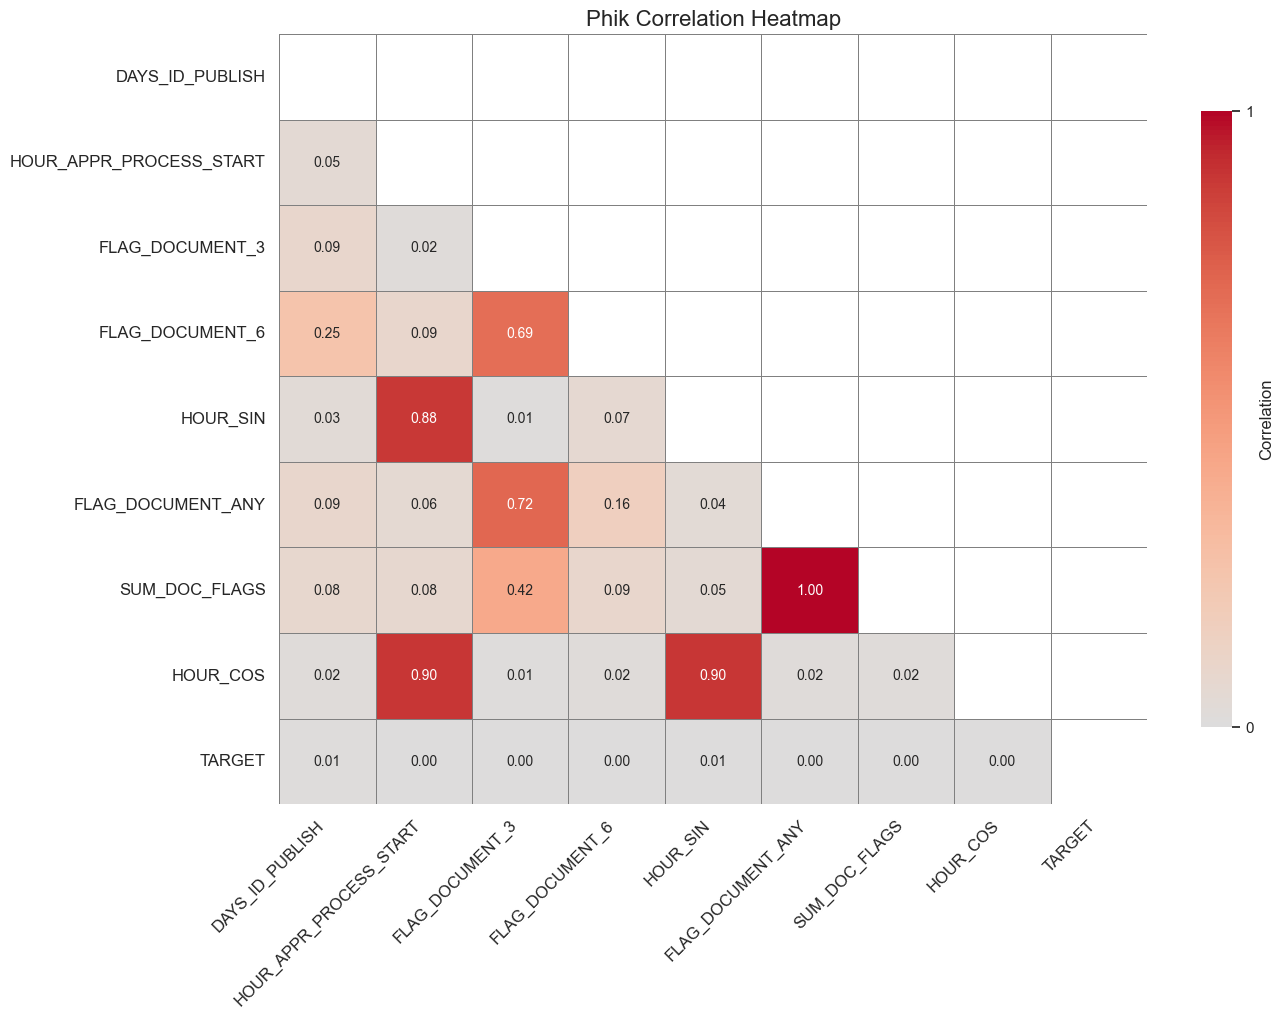

In [20]:
ax = plot_correlation_matrix(application_phik)

In [21]:
correlation_threshold(application_phik, 0.8)

,Column 1,Column 2,Correlation
2,HOUR_APPR_PROCESS_START,HOUR_SIN,0.88440
3,HOUR_APPR_PROCESS_START,HOUR_COS,0.89670
8,HOUR_COS,HOUR_SIN,0.89512
10,FLAG_DOCUMENT_ANY,SUM_DOC_FLAGS,1.00000


__Features to keep:__
- DAYS_ID_PUBLISH 
- HOUR_SIN and HOUR_COS:<br>
- FLAG_DOCUMENT Columns 

(side note: in earlier iterations, I chose to use multiple correspondence analysis (MCA) to reduce the dimensionality of the document flags, however, I determined this was not a useful technique for the current analysis. However, [Prince](https://maxhalford.github.io/prince/mca/) is a package that offers this functionality and other factor analyses.)

#### Car Info
Features regarding car ownership

In [22]:
car_feats = ["FLAG_OWN_CAR", "OWN_CAR_AGE"]

In [23]:
car_feat_df = X_train[car_feats].copy()
car_feat_df = car_feat_df.reset_index().drop(["index"], axis=1)
car_feat_df

,FLAG_OWN_CAR,OWN_CAR_AGE
0,N,NaN
1,N,NaN
2,N,NaN
3,Y,4.00000
4,N,NaN
...,...,...
196801,N,NaN
196802,Y,17.00000
196803,Y,7.00000
196804,Y,2.00000


In [24]:
car_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196806 entries, 0 to 196805
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   FLAG_OWN_CAR  196806 non-null  object 
 1   OWN_CAR_AGE   66693 non-null   float16
dtypes: float16(1), object(1)
memory usage: 1.9+ MB


__FLAG_OWN_CAR:__
_Flag if the client owns a car_

__OWN_CAR_AGE:__
_Age of client's car_

##### Impute Missing Values and Feature Engineering

There are many missing values for OWN_CAR_AGE, but no missing values for FLAG_OWN_CAR <br>
If FLAG_OWN_CAR is N, then I will change the OWN_CAR_AGE to 0<br>
If there are still any unknown OWN_CAR_AGE, then I will also make them 0, but include an indicator column called "CAR_AGE_UNKNOWN"

In [25]:
car_feat_df["OWN_CAR_AGE"] = np.where(
    car_feat_df["FLAG_OWN_CAR"] == "N", 0, car_feat_df["OWN_CAR_AGE"]
)
car_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196806 entries, 0 to 196805
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   FLAG_OWN_CAR  196806 non-null  object 
 1   OWN_CAR_AGE   196802 non-null  float16
dtypes: float16(1), object(1)
memory usage: 1.9+ MB


In [26]:
car_feat_df["CAR_AGE_UNKNOWN"] = np.where(car_feat_df["OWN_CAR_AGE"].isna(), 1, 0)
car_feat_df["OWN_CAR_AGE"] = np.where(
    car_feat_df["OWN_CAR_AGE"].isna(), 0, car_feat_df["OWN_CAR_AGE"]
)
car_feat_df

,FLAG_OWN_CAR,OWN_CAR_AGE,CAR_AGE_UNKNOWN
0,N,0.00000,0
1,N,0.00000,0
2,N,0.00000,0
3,Y,4.00000,0
4,N,0.00000,0
...,...,...,...
196801,N,0.00000,0
196802,Y,17.00000,0
196803,Y,7.00000,0
196804,Y,2.00000,0


##### Feature Selection - Boruta

In [27]:
car_feat_df_boruta, _ = boruta_feature_selection(car_feat_df, y_train.values.ravel())
car_feat_df_boruta

Iteration: 	1 / 40
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	2 / 40
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	3 / 40
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	4 / 40
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	5 / 40
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	6 / 40
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	7 / 40
Confirmed: 	0
Tentative: 	4
Rejected: 	0
Iteration: 	8 / 40
Confirmed: 	1
Tentative: 	2
Rejected: 	1
Iteration: 	9 / 40
Confirmed: 	1
Tentative: 	2
Rejected: 	1
Iteration: 	10 / 40
Confirmed: 	1
Tentative: 	2
Rejected: 	1
Iteration: 	11 / 40
Confirmed: 	1
Tentative: 	2
Rejected: 	1
Iteration: 	12 / 40
Confirmed: 	1
Tentative: 	2
Rejected: 	1
Iteration: 	13 / 40
Confirmed: 	1
Tentative: 	2
Rejected: 	1
Iteration: 	14 / 40
Confirmed: 	1
Tentative: 	2
Rejected: 	1
Iteration: 	15 / 40
Confirmed: 	1
Tentative: 	2
Rejected: 	1
Iteration: 	16 / 40
Confirmed: 	1
Tentative: 	2
Rejected: 	1
Iteration: 	17 / 40
Confirmed: 	1

,OWN_CAR_AGE,FLAG_OWN_CAR_Y
0,0.00000,0.00000
1,0.00000,0.00000
2,0.00000,0.00000
3,4.00000,1.00000
4,0.00000,0.00000
...,...,...
196801,0.00000,0.00000
196802,17.00000,1.00000
196803,7.00000,1.00000
196804,2.00000,1.00000


##### Correlation EDA

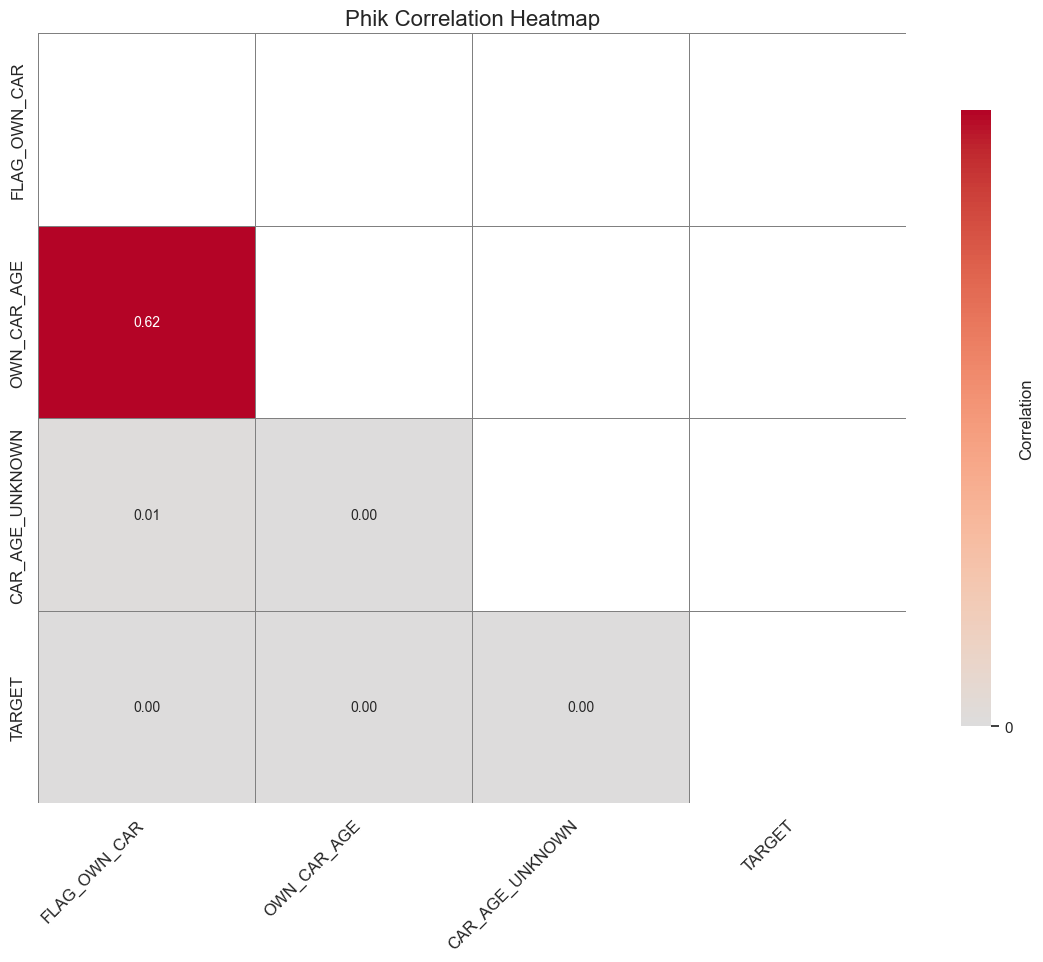

,Column 1,Column 2,Correlation


In [28]:
interval_cols = ["OWN_CAR_AGE"]
car_phik = pd.concat([car_feat_df, y_train], axis=1).phik_matrix(
    interval_cols=interval_cols
)
ax = plot_correlation_matrix(car_phik)
correlation_threshold(car_phik, 0.8)

__Features to Keep__:<br>
- FLAG_OWN_CAR
- OWN_CAR_AGE

Note: Boruta is not finding indicator columns to provide much information.

#### Contact Info <a class="anchor" id="section1_4_1"></a>
Phone, and email related features.

In [29]:
contact_feats = [
    "FLAG_MOBIL",
    "FLAG_EMP_PHONE",
    "FLAG_WORK_PHONE",
    "FLAG_CONT_MOBILE",
    "FLAG_PHONE",
    "FLAG_EMAIL",
    "DAYS_LAST_PHONE_CHANGE",
]

In [30]:
contact_feat_df = X_train[contact_feats].copy()
contact_feat_df = contact_feat_df.reset_index().drop(["index"], axis=1)
contact_feat_df

,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,DAYS_LAST_PHONE_CHANGE
0,1,1,0,1,0,0,-1961.00000
1,1,1,0,1,1,1,-1180.00000
2,1,1,0,1,0,0,0.00000
3,1,1,0,1,0,0,-1634.00000
4,1,1,0,1,0,0,-1145.00000
...,...,...,...,...,...,...,...
196801,1,1,0,1,1,0,-1123.00000
196802,1,1,0,1,0,0,-865.00000
196803,1,1,1,1,1,0,-3012.00000
196804,1,1,0,1,0,0,-762.00000


In [31]:
contact_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196806 entries, 0 to 196805
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   FLAG_MOBIL              196806 non-null  int8   
 1   FLAG_EMP_PHONE          196806 non-null  int8   
 2   FLAG_WORK_PHONE         196806 non-null  int8   
 3   FLAG_CONT_MOBILE        196806 non-null  int8   
 4   FLAG_PHONE              196806 non-null  int8   
 5   FLAG_EMAIL              196806 non-null  int8   
 6   DAYS_LAST_PHONE_CHANGE  196805 non-null  float16
dtypes: float16(1), int8(6)
memory usage: 1.5 MB


##### Impute Missing Values

There is only one missing value <br><br>
__DAYS_LAST_PHONE_CHANGE:__
_How many days before application did client change phone_


In [32]:
contact_feat_df[contact_feat_df["DAYS_LAST_PHONE_CHANGE"].isna()]

,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,DAYS_LAST_PHONE_CHANGE
76193,0,1,0,1,0,0,NaN


For now, I will convert that NaN value to a 0.<br><br> {Note: due to the large amount of data and relative sparseness of many missing categories, my final decision is to impute with 0 instead of dropping values. I use Boruta and indicator columns to deal with missing values and if Boruta suggests the feature is useful, even with 0's in it, then I will deem it useful for machine learning.}

In [33]:
contact_feat_df["DAYS_LAST_PHONE_CHANGE"] = np.where(
    contact_feat_df["DAYS_LAST_PHONE_CHANGE"].isna(),
    0,
    contact_feat_df["DAYS_LAST_PHONE_CHANGE"],
)

##### Feature Selection - Boruta

In [34]:
contact_feat_df_boruta, _ = boruta_feature_selection(
    contact_feat_df, y_train.values.ravel()
)
contact_feat_df_boruta

Iteration: 	1 / 40
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	2 / 40
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	3 / 40
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	4 / 40
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	5 / 40
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	6 / 40
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	7 / 40
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	8 / 40
Confirmed: 	4
Tentative: 	0
Rejected: 	3


BorutaPy finished running.

Iteration: 	9 / 40
Confirmed: 	4
Tentative: 	0
Rejected: 	3


,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,DAYS_LAST_PHONE_CHANGE
0,1,0,0,-1961.00000
1,1,0,1,-1180.00000
2,1,0,0,0.00000
3,1,0,0,-1634.00000
4,1,0,0,-1145.00000
...,...,...,...,...
196801,1,0,1,-1123.00000
196802,1,0,0,-865.00000
196803,1,1,1,-3012.00000
196804,1,0,0,-762.00000


##### Correlation EDA

In [35]:
contact_feat_df.columns

Index(['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'DAYS_LAST_PHONE_CHANGE'],
      dtype='object')

In [36]:
contact_feat_df_boruta.columns

Index(['FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'DAYS_LAST_PHONE_CHANGE'],
      dtype='object')

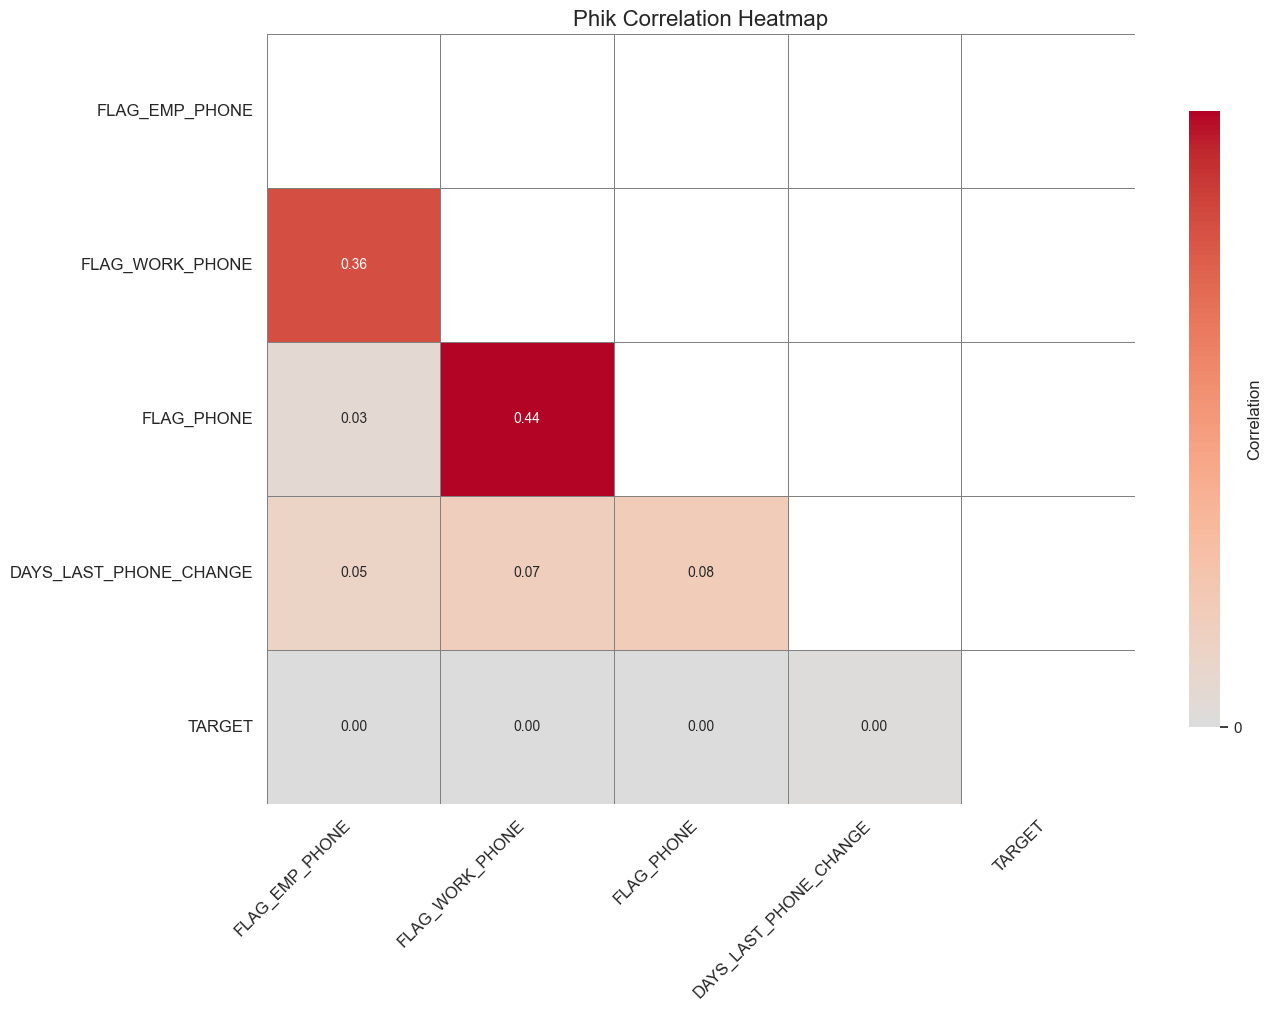

,Column 1,Column 2,Correlation


In [37]:
contact_feat_post_boruta = pd.concat(
    [contact_feat_df[list(contact_feat_df_boruta.columns)]],
    axis=1,
)
interval_cols = ["DAYS_LAST_PHONE_CHANGE"]
contact_phik = pd.concat([contact_feat_post_boruta, y_train], axis=1).phik_matrix(
    interval_cols=interval_cols
)
ax = plot_correlation_matrix(contact_phik)
correlation_threshold(contact_phik, threshold=0.8)

__Features to Keep:__
- FLAG features
- DAYS_LAST_PHONE_CHANGE 

#### Demographic Info 
These features include things like gender, date of birth, education, and where the person is from.

In [38]:
demographic_feats = [
    "CODE_GENDER",
    "DAYS_BIRTH",
    "NAME_EDUCATION_TYPE",
    "REGION_POPULATION_RELATIVE",
    "REGION_RATING_CLIENT",
    "REGION_RATING_CLIENT_W_CITY",
]

In [39]:
demographic_feat_df = X_train[demographic_feats].copy()
demographic_feat_df = demographic_feat_df.reset_index().drop(["index"], axis=1)
demographic_feat_df

,CODE_GENDER,DAYS_BIRTH,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY
0,F,-19705,Secondary / secondary special,0.01056,3,3
1,F,-14010,Higher education,0.02461,2,2
2,F,-18047,Secondary / secondary special,0.02461,2,2
3,F,-16037,Secondary / secondary special,0.03580,2,2
4,M,-18036,Secondary / secondary special,0.02516,2,2
...,...,...,...,...,...,...
196801,F,-8383,Secondary / secondary special,0.00963,2,2
196802,F,-17379,Secondary / secondary special,0.00966,2,2
196803,M,-11894,Higher education,0.03076,2,2
196804,F,-18279,Higher education,0.00862,2,2


In [40]:
demographic_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196806 entries, 0 to 196805
Data columns (total 6 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   CODE_GENDER                  196806 non-null  object 
 1   DAYS_BIRTH                   196806 non-null  int16  
 2   NAME_EDUCATION_TYPE          196806 non-null  object 
 3   REGION_POPULATION_RELATIVE   196806 non-null  float16
 4   REGION_RATING_CLIENT         196806 non-null  int8   
 5   REGION_RATING_CLIENT_W_CITY  196806 non-null  int8   
dtypes: float16(1), int16(1), int8(2), object(2)
memory usage: 4.1+ MB


__CODE_GENDER:__
_Gender of the client_

__DAYS_BIRTH:__
_Client's age in days at the time of application_

__NAME_EDUCATION_TYPE:__
_Level of highest education the client achieved_

__REGION_POPULATION_RELATIVE:__
_Normalized population of region where client lives (higher number means the client lives in more populated region)_

__REGION_RATING_CLIENT:__
_Our rating of the region where client lives (1,2,3)_

__REGION_RATING_CLIENT_W_CITY:__
_Our rating of the region where client lives with taking city into account (1,2,3)_

No missing values to impute. No preliminary feature engineering necessary.  

##### Feature Selection - Boruta

In [41]:
demographic_feat_df_boruta, _ = boruta_feature_selection(
    demographic_feat_df, y_train.values.ravel()
)
demographic_feat_df_boruta

Iteration: 	1 / 40
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 40
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 40
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 40
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 40
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 40
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 40
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 40
Confirmed: 	8
Tentative: 	0
Rejected: 	4


BorutaPy finished running.

Iteration: 	9 / 40
Confirmed: 	8
Tentative: 	0
Rejected: 	4


,DAYS_BIRTH,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,CODE_GENDER_F,CODE_GENDER_M,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special
0,-19705,0.01056,3,3,1.00000,0.00000,0.00000,1.00000
1,-14010,0.02461,2,2,1.00000,0.00000,1.00000,0.00000
2,-18047,0.02461,2,2,1.00000,0.00000,0.00000,1.00000
3,-16037,0.03580,2,2,1.00000,0.00000,0.00000,1.00000
4,-18036,0.02516,2,2,0.00000,1.00000,0.00000,1.00000
...,...,...,...,...,...,...,...,...
196801,-8383,0.00963,2,2,1.00000,0.00000,0.00000,1.00000
196802,-17379,0.00966,2,2,1.00000,0.00000,0.00000,1.00000
196803,-11894,0.03076,2,2,0.00000,1.00000,1.00000,0.00000
196804,-18279,0.00862,2,2,1.00000,0.00000,1.00000,0.00000


##### Correlation EDA

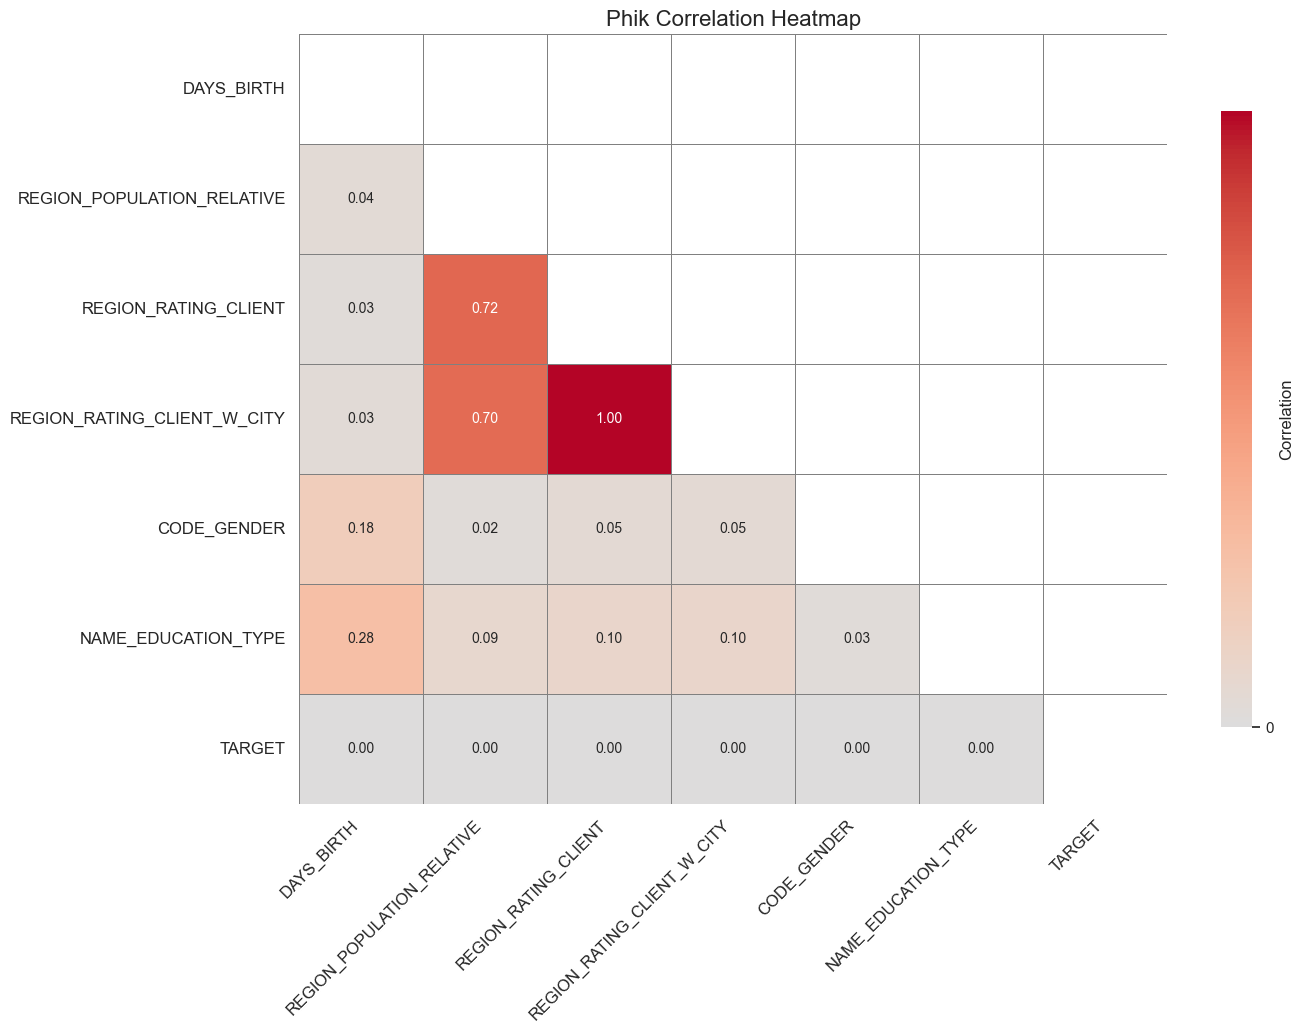

,Column 1,Column 2,Correlation
3,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,0.99879


In [42]:
demographic_feat_post_boruta = demographic_feat_df[
    [
        "DAYS_BIRTH",
        "REGION_POPULATION_RELATIVE",
        "REGION_RATING_CLIENT",
        "REGION_RATING_CLIENT_W_CITY",
        "CODE_GENDER",
        "NAME_EDUCATION_TYPE",
    ]
]
interval_cols = ["DAYS_BIRTH", "REGION_POPULATION_RELATIVE"]
demographic_phik = pd.concat(
    [demographic_feat_post_boruta, y_train], axis=1
).phik_matrix(interval_cols=interval_cols)
ax = plot_correlation_matrix(demographic_phik)
correlation_threshold(demographic_phik, threshold=0.8)

__Features to keep:__
- DAYS_BIRTH
- REGION_POPULATION_RELATIVE
- REGION_RATING_CLIENT (NOTE: REGION_RATING_CLIENT_W_CITY IS REDUNDANT) 
- CODE_GENDER
- NAME_EDUCATION_TYPE 

#### Family and Social Info 
More demographic information, but this time specifically related to family and social relationships. 

In [43]:
family_social_feats = [
    "CNT_CHILDREN",
    "NAME_TYPE_SUITE",
    "NAME_FAMILY_STATUS",
    "CNT_FAM_MEMBERS",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
]

In [44]:
family_social_feat_df = X_train[family_social_feats].copy()
family_social_feat_df = family_social_feat_df.reset_index().drop(["index"], axis=1)
family_social_feat_df

,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_FAMILY_STATUS,CNT_FAM_MEMBERS,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
0,0,Unaccompanied,Separated,1.00000,0.00000,0.00000,0.00000,0.00000
1,0,Unaccompanied,Single / not married,1.00000,0.00000,0.00000,0.00000,0.00000
2,0,"Spouse, partner",Married,2.00000,1.00000,0.00000,1.00000,0.00000
3,1,Unaccompanied,Married,3.00000,0.00000,0.00000,0.00000,0.00000
4,0,"Spouse, partner",Married,2.00000,9.00000,0.00000,9.00000,0.00000
...,...,...,...,...,...,...,...,...
196801,0,Unaccompanied,Married,2.00000,0.00000,0.00000,0.00000,0.00000
196802,0,Unaccompanied,Married,2.00000,0.00000,0.00000,0.00000,0.00000
196803,0,Unaccompanied,Single / not married,1.00000,0.00000,0.00000,0.00000,0.00000
196804,0,Unaccompanied,Married,2.00000,0.00000,0.00000,0.00000,0.00000


In [45]:
family_social_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196806 entries, 0 to 196805
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   CNT_CHILDREN              196806 non-null  int8   
 1   NAME_TYPE_SUITE           196021 non-null  object 
 2   NAME_FAMILY_STATUS        196806 non-null  object 
 3   CNT_FAM_MEMBERS           196804 non-null  float16
 4   OBS_30_CNT_SOCIAL_CIRCLE  196167 non-null  float16
 5   DEF_30_CNT_SOCIAL_CIRCLE  196167 non-null  float16
 6   OBS_60_CNT_SOCIAL_CIRCLE  196167 non-null  float16
 7   DEF_60_CNT_SOCIAL_CIRCLE  196167 non-null  float16
dtypes: float16(5), int8(1), object(2)
memory usage: 5.1+ MB


##### Impute Missing Values

__NAME_TYPE_SUITE:__
_Who was accompanying client when he was applying for the loan_

__CNT_FAM_MEMBERS:__
_How many family members does client have_

__OBS_30_CNT_SOCIAL_CIRCLE:__
_How many observation of client's social surroundings with observable 30 DPD (days past due) default_

__DEF_30_CNT_SOCIAL_CIRCLE:__
_How many observation of client's social surroundings defaulted on 30 DPD (days past due)_

__OBS_60_CUT_SOCIAL_CIRCLE:__
_How many observation of client's social surroundings with observable 60 DPD (days past due) default_

__DEF_60_CNT_SOCIAL_CIRCLE:__
_How many observation of client's social surroundings defaulted on 60 (days past due) DPD_

In [46]:
family_social_feat_df = family_social_feat_df.fillna(
    {
        "NAME_TYPE_SUITE": "UNKNOWN",
        "CNT_FAM_MEMBERS": 0,
        "OBS_30_CNT_SOCIAL_CIRCLE": 0,
        "DEF_30_CNT_SOCIAL_CIRCLE": 0,
        "OBS_60_CNT_SOCIAL_CIRCLE": 0,
        "DEF_60_CNT_SOCIAL_CIRCLE": 0,
    }
)

##### Feature Selection - Boruta

In [47]:
family_social_feat_df_boruta, _ = boruta_feature_selection(
    family_social_feat_df, y_train.values.ravel()
)
family_social_feat_df_boruta

Iteration: 	1 / 40
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	2 / 40
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	3 / 40
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	4 / 40
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	5 / 40
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	6 / 40
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	7 / 40
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	8 / 40
Confirmed: 	9
Tentative: 	1
Rejected: 	10
Iteration: 	9 / 40
Confirmed: 	9
Tentative: 	1
Rejected: 	10
Iteration: 	10 / 40
Confirmed: 	9
Tentative: 	1
Rejected: 	10
Iteration: 	11 / 40
Confirmed: 	9
Tentative: 	1
Rejected: 	10
Iteration: 	12 / 40
Confirmed: 	10
Tentative: 	0
Rejected: 	10


BorutaPy finished running.

Iteration: 	13 / 40
Confirmed: 	10
Tentative: 	0
Rejected: 	10


,CNT_CHILDREN,CNT_FAM_MEMBERS,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow
0,0,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
2,0,2.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000
3,1,3.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
4,0,2.00000,9.00000,0.00000,9.00000,0.00000,0.00000,1.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...
196801,0,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
196802,0,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
196803,0,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
196804,0,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000


##### Correlation EDA

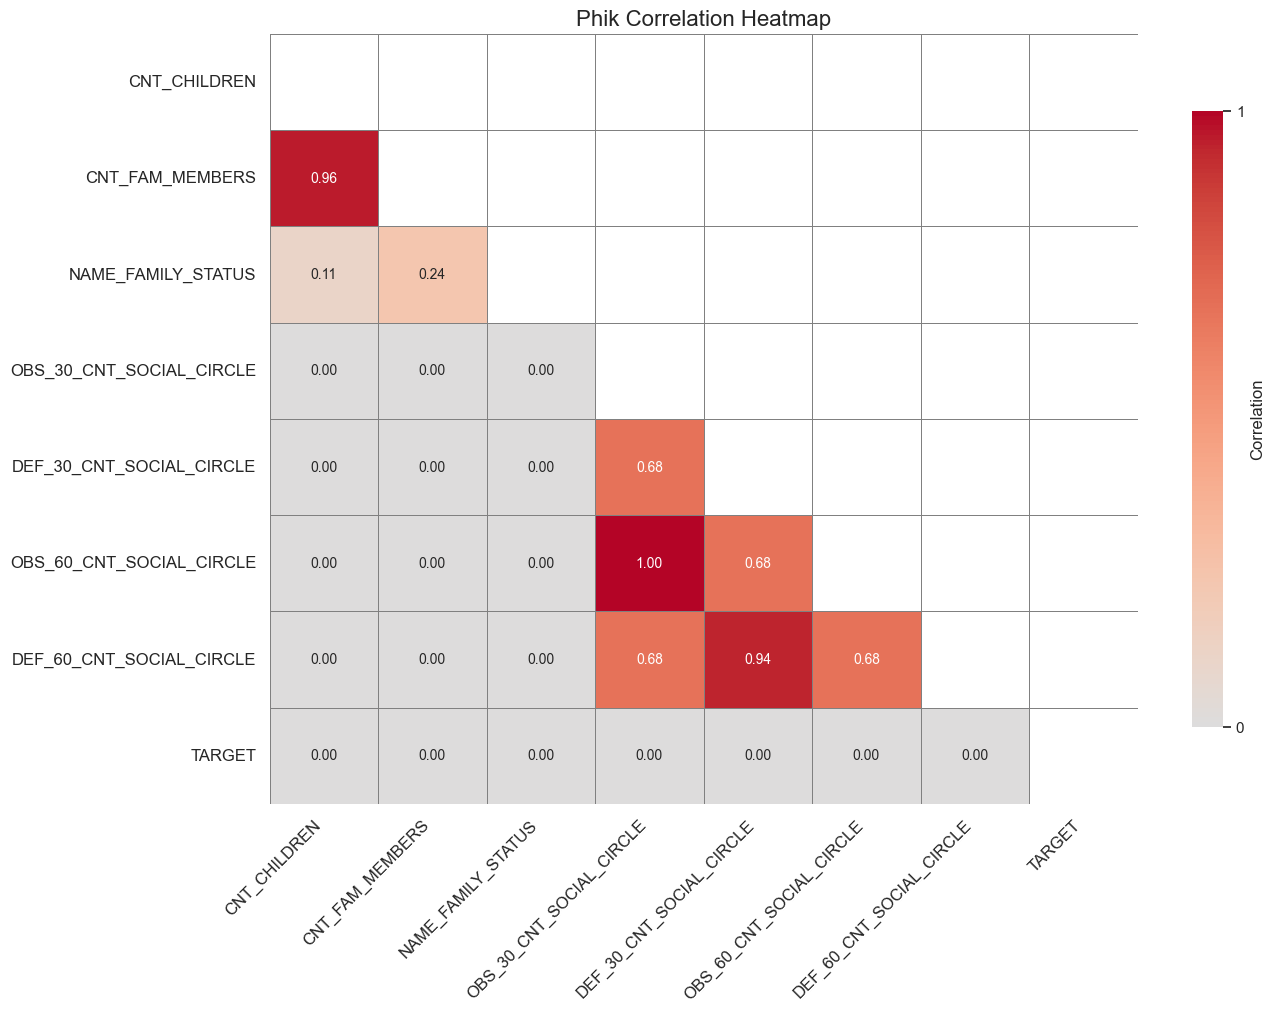

,Column 1,Column 2,Correlation
1,CNT_CHILDREN,CNT_FAM_MEMBERS,0.95934
6,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,1.00000
8,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,0.94101


In [48]:
family_social_feat_post_boruta = family_social_feat_df[
    [
        "CNT_CHILDREN",
        "CNT_FAM_MEMBERS",
        "NAME_FAMILY_STATUS",
        "OBS_30_CNT_SOCIAL_CIRCLE",
        "DEF_30_CNT_SOCIAL_CIRCLE",
        "OBS_60_CNT_SOCIAL_CIRCLE",
        "DEF_60_CNT_SOCIAL_CIRCLE",
    ]
]
interval_cols = [
    "CNT_CHILDREN",
    "CNT_FAM_MEMBERS",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
]
family_social_phik = pd.concat(
    [family_social_feat_post_boruta, y_train], axis=1
).phik_matrix(interval_cols=interval_cols)
ax = plot_correlation_matrix(family_social_phik)
correlation_threshold(family_social_phik, threshold=0.8)

__Features to Keep:__ 
- CNT_FAMILY_MEMBERS
- NAME_FAMILY_STATUS
- OBS_60_CNT_SOCIAL_CIRCLE
- DEF_60_CNT_SOCIAL_CIRCLE

#### Financial Info
Information from other financial agencies such as Credit Bureau and other external sources.

In [49]:
financial_feats = [
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "AMT_REQ_CREDIT_BUREAU_HOUR",
    "AMT_REQ_CREDIT_BUREAU_DAY",
    "AMT_REQ_CREDIT_BUREAU_WEEK",
    "AMT_REQ_CREDIT_BUREAU_MON",
    "AMT_REQ_CREDIT_BUREAU_QRT",
    "AMT_REQ_CREDIT_BUREAU_YEAR",
]

In [50]:
financial_feat_df = X_train[financial_feats].copy()
financial_feat_df = financial_feat_df.reset_index().drop(["index"], axis=1)
financial_feat_df

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,NaN,0.39087,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.46045,0.63623,0.22388,0.00000,0.00000,0.00000,0.00000,1.00000,5.00000
2,0.47803,0.64160,0.51172,0.00000,0.00000,0.00000,4.00000,0.00000,0.00000
3,0.04544,0.47266,0.23926,0.00000,0.00000,0.00000,0.00000,0.00000,9.00000
4,NaN,0.49878,0.60254,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
...,...,...,...,...,...,...,...,...,...
196801,0.41504,0.51465,0.38940,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
196802,NaN,0.59521,0.38428,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000
196803,NaN,0.26538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196804,NaN,0.77148,0.56006,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [51]:
financial_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196806 entries, 0 to 196805
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   EXT_SOURCE_1                86029 non-null   float16
 1   EXT_SOURCE_2                196392 non-null  float16
 2   EXT_SOURCE_3                157793 non-null  float16
 3   AMT_REQ_CREDIT_BUREAU_HOUR  170310 non-null  float16
 4   AMT_REQ_CREDIT_BUREAU_DAY   170310 non-null  float16
 5   AMT_REQ_CREDIT_BUREAU_WEEK  170310 non-null  float16
 6   AMT_REQ_CREDIT_BUREAU_MON   170310 non-null  float16
 7   AMT_REQ_CREDIT_BUREAU_QRT   170310 non-null  float16
 8   AMT_REQ_CREDIT_BUREAU_YEAR  170310 non-null  float16
dtypes: float16(9)
memory usage: 3.4 MB


__EXT_SOURCE_(N):__
_Normalized score from external data source_
- According to a [SweetViz](https://towardsdatascience.com/sweetviz-automated-eda-in-python-a97e4cabacde) analysis I ran these features seem to be quite important.

__AMT_REQ_CREDIT_BUREAU_(PERIOD):_
_Number of enquiries to Credit Bureau about the client (PERIOD) before application_

##### Feature Engineering and Missing Value Imputation 
Note: For this I will perform aggregations and do feature engineering prior to imputing. 
- take an average, min, max, median, std of EXT_SOURCE_1, 2, AND 3
- do indicator column for anything that's missing for EXT1,2,3
- do indicator if any missing AMT_REQ_CREDIT_BUREAU
- convert rest to 0 

In [52]:
financial_feat_df["EXT_SOURCE_MEAN"] = financial_feat_df[
    ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
].mean(axis=1)
financial_feat_df["EXT_SOURCE_STD"] = financial_feat_df[
    ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
].std(axis=1)
financial_feat_df["EXT_SOURCE_MEDIAN"] = financial_feat_df[
    ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
].median(axis=1)
financial_feat_df["EXT_SOURCE_MIN"] = financial_feat_df[
    ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
].min(axis=1)
financial_feat_df["EXT_SOURCE_MAX"] = financial_feat_df[
    ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
].max(axis=1)

In [53]:
financial_feat_df["EXT_SOURCE_1_MISSING"] = (
    financial_feat_df["EXT_SOURCE_1"].isnull().astype(int)
)
financial_feat_df["EXT_SOURCE_2_MISSING"] = (
    financial_feat_df["EXT_SOURCE_2"].isnull().astype(int)
)
financial_feat_df["EXT_SOURCE_3_MISSING"] = (
    financial_feat_df["EXT_SOURCE_3"].isnull().astype(int)
)

In [54]:
financial_feat_df["ANY_EXT_SOURCE_MISSING"] = (
    financial_feat_df[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]]
    .isnull()
    .any(axis=1)
    .astype(int)
)

In [55]:
financial_feat_df["CREDIT_BUREAU_INQ_MISSING"] = (
    financial_feat_df[
        [
            "AMT_REQ_CREDIT_BUREAU_DAY",
            "AMT_REQ_CREDIT_BUREAU_HOUR",
            "AMT_REQ_CREDIT_BUREAU_MON",
            "AMT_REQ_CREDIT_BUREAU_QRT",
            "AMT_REQ_CREDIT_BUREAU_WEEK",
            "AMT_REQ_CREDIT_BUREAU_YEAR",
        ]
    ]
    .isnull()
    .any(axis=1)
    .astype(int)
)

In [56]:
financial_feat_df = financial_feat_df.fillna(0)
financial_feat_df

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_MEAN,EXT_SOURCE_STD,EXT_SOURCE_MEDIAN,EXT_SOURCE_MIN,EXT_SOURCE_MAX,EXT_SOURCE_1_MISSING,EXT_SOURCE_2_MISSING,EXT_SOURCE_3_MISSING,ANY_EXT_SOURCE_MISSING,CREDIT_BUREAU_INQ_MISSING
0,0.00000,0.39087,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.39087,0.00000,0.39087,0.39087,0.39087,1,0,1,1,1
1,0.46045,0.63623,0.22388,0.00000,0.00000,0.00000,0.00000,1.00000,5.00000,0.44019,0.20691,0.46045,0.22388,0.63623,0,0,0,0,0
2,0.47803,0.64160,0.51172,0.00000,0.00000,0.00000,4.00000,0.00000,0.00000,0.54346,0.08636,0.51172,0.47803,0.64160,0,0,0,0,0
3,0.04544,0.47266,0.23926,0.00000,0.00000,0.00000,0.00000,0.00000,9.00000,0.25244,0.21387,0.23926,0.04544,0.47266,0,0,0,0,0
4,0.00000,0.49878,0.60254,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.55078,0.07336,0.55078,0.49878,0.60254,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196801,0.41504,0.51465,0.38940,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.43970,0.06616,0.41504,0.38940,0.51465,0,0,0,0,0
196802,0.00000,0.59521,0.38428,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,0.48975,0.14917,0.48975,0.38428,0.59521,1,0,0,1,0
196803,0.00000,0.26538,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.26538,0.00000,0.26538,0.26538,0.26538,1,0,1,1,1
196804,0.00000,0.77148,0.56006,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.66602,0.14954,0.66602,0.56006,0.77148,1,0,0,1,0


##### Feature Selection - Boruta

In [57]:
financial_feat_df_boruta, _ = boruta_feature_selection(
    financial_feat_df, y_train.values.ravel()
)
financial_feat_df_boruta

Iteration: 	1 / 40
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	2 / 40
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	3 / 40
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	4 / 40
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	5 / 40
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	6 / 40
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	7 / 40
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	8 / 40
Confirmed: 	12
Tentative: 	0
Rejected: 	7


BorutaPy finished running.

Iteration: 	9 / 40
Confirmed: 	12
Tentative: 	0
Rejected: 	7


,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_MEAN,EXT_SOURCE_STD,EXT_SOURCE_MEDIAN,EXT_SOURCE_MIN,EXT_SOURCE_MAX,EXT_SOURCE_1_MISSING,EXT_SOURCE_3_MISSING,ANY_EXT_SOURCE_MISSING,CREDIT_BUREAU_INQ_MISSING
0,0.00000,0.39087,0.00000,0.39087,0.00000,0.39087,0.39087,0.39087,1,1,1,1
1,0.46045,0.63623,0.22388,0.44019,0.20691,0.46045,0.22388,0.63623,0,0,0,0
2,0.47803,0.64160,0.51172,0.54346,0.08636,0.51172,0.47803,0.64160,0,0,0,0
3,0.04544,0.47266,0.23926,0.25244,0.21387,0.23926,0.04544,0.47266,0,0,0,0
4,0.00000,0.49878,0.60254,0.55078,0.07336,0.55078,0.49878,0.60254,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
196801,0.41504,0.51465,0.38940,0.43970,0.06616,0.41504,0.38940,0.51465,0,0,0,0
196802,0.00000,0.59521,0.38428,0.48975,0.14917,0.48975,0.38428,0.59521,1,0,1,0
196803,0.00000,0.26538,0.00000,0.26538,0.00000,0.26538,0.26538,0.26538,1,1,1,1
196804,0.00000,0.77148,0.56006,0.66602,0.14954,0.66602,0.56006,0.77148,1,0,1,0


##### Correlation EDA

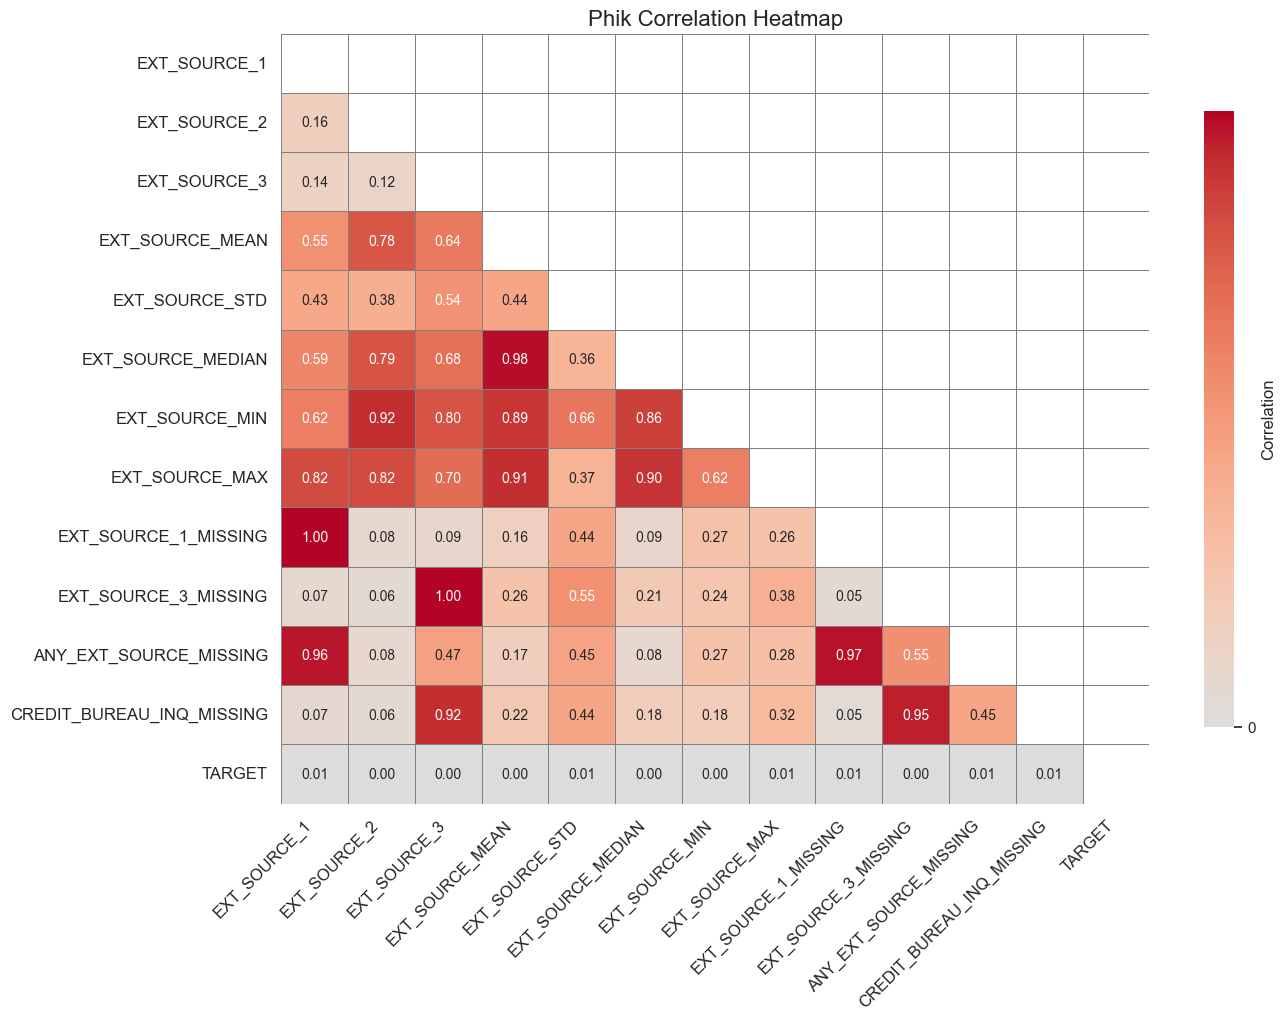

,Column 1,Column 2,Correlation
1,EXT_SOURCE_1,EXT_SOURCE_MAX,0.82459
2,EXT_SOURCE_1,EXT_SOURCE_1_MISSING,0.99981
3,ANY_EXT_SOURCE_MISSING,EXT_SOURCE_1,0.96372
5,EXT_SOURCE_2,EXT_SOURCE_MIN,0.91538
6,EXT_SOURCE_2,EXT_SOURCE_MAX,0.82104
8,EXT_SOURCE_3,EXT_SOURCE_MIN,0.80436
9,EXT_SOURCE_3,EXT_SOURCE_3_MISSING,0.99770
10,CREDIT_BUREAU_INQ_MISSING,EXT_SOURCE_3,0.91702
12,EXT_SOURCE_MEAN,EXT_SOURCE_MEDIAN,0.97757
13,EXT_SOURCE_MEAN,EXT_SOURCE_MIN,0.89082


In [58]:
financial_feat_post_boruta = financial_feat_df[
    [
        "EXT_SOURCE_1",
        "EXT_SOURCE_2",
        "EXT_SOURCE_3",
        "EXT_SOURCE_MEAN",
        "EXT_SOURCE_STD",
        "EXT_SOURCE_MEDIAN",
        "EXT_SOURCE_MIN",
        "EXT_SOURCE_MAX",
        "EXT_SOURCE_1_MISSING",
        "EXT_SOURCE_3_MISSING",
        "ANY_EXT_SOURCE_MISSING",
        "CREDIT_BUREAU_INQ_MISSING",
    ]
]
interval_cols = [
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "EXT_SOURCE_MEAN",
    "EXT_SOURCE_STD",
    "EXT_SOURCE_MEDIAN",
    "EXT_SOURCE_MIN",
    "EXT_SOURCE_MAX",
]
financial_phik = pd.concat([financial_feat_post_boruta, y_train], axis=1).phik_matrix(
    interval_cols=interval_cols
)
ax = plot_correlation_matrix(financial_phik)
correlation_threshold(financial_phik, threshold=0.8)

In [59]:
financial_phik["TARGET"].sort_values(ascending=False)

TARGET                      1.00000
EXT_SOURCE_1                0.00787
ANY_EXT_SOURCE_MISSING      0.00685
EXT_SOURCE_STD              0.00671
EXT_SOURCE_1_MISSING        0.00524
EXT_SOURCE_MAX              0.00524
CREDIT_BUREAU_INQ_MISSING   0.00501
EXT_SOURCE_MIN              0.00379
EXT_SOURCE_2                0.00000
EXT_SOURCE_MEAN             0.00000
EXT_SOURCE_3                0.00000
EXT_SOURCE_MEDIAN           0.00000
EXT_SOURCE_3_MISSING        0.00000
Name: TARGET, dtype: float64

__Features to Keep__
- EXT_SOURCE_1
- EXT_SOURCE_2
- EXT_SOURCE_3
- ANY_EXT_SOURCE_MISSING
- CREDIT_BUREAU_INQ_MISSING
- EXT_SOURCE_MEAN
- EXT_SOURCE_STD
- and perhaps others such as EXT_SOURCE_MAX and EXT_SOURCE_MIN.

#### Housing Info 
Information related to the homes of the applicants.

In [60]:
housing_feats = [
    "DAYS_REGISTRATION",
    "FLAG_OWN_REALTY",
    "NAME_HOUSING_TYPE",
    "REG_REGION_NOT_LIVE_REGION",
    "REG_REGION_NOT_WORK_REGION",
    "LIVE_REGION_NOT_WORK_REGION",
    "REG_CITY_NOT_LIVE_CITY",
    "REG_CITY_NOT_WORK_CITY",
    "LIVE_CITY_NOT_WORK_CITY",
    "APARTMENTS_AVG",
    "BASEMENTAREA_AVG",
    "YEARS_BEGINEXPLUATATION_AVG",
    "YEARS_BUILD_AVG",
    "COMMONAREA_AVG",
    "ELEVATORS_AVG",
    "ENTRANCES_AVG",
    "FLOORSMAX_AVG",
    "FLOORSMIN_AVG",
    "LANDAREA_AVG",
    "LIVINGAPARTMENTS_AVG",
    "LIVINGAREA_AVG",
    "NONLIVINGAPARTMENTS_AVG",
    "NONLIVINGAREA_AVG",
    "APARTMENTS_MODE",
    "BASEMENTAREA_MODE",
    "YEARS_BEGINEXPLUATATION_MODE",
    "YEARS_BUILD_MODE",
    "COMMONAREA_MODE",
    "ELEVATORS_MODE",
    "ENTRANCES_MODE",
    "FLOORSMAX_MODE",
    "FLOORSMIN_MODE",
    "LANDAREA_MODE",
    "LIVINGAPARTMENTS_MODE",
    "LIVINGAREA_MODE",
    "NONLIVINGAPARTMENTS_MODE",
    "NONLIVINGAREA_MODE",
    "APARTMENTS_MEDI",
    "BASEMENTAREA_MEDI",
    "YEARS_BEGINEXPLUATATION_MEDI",
    "YEARS_BUILD_MEDI",
    "COMMONAREA_MEDI",
    "ELEVATORS_MEDI",
    "ENTRANCES_MEDI",
    "FLOORSMAX_MEDI",
    "FLOORSMIN_MEDI",
    "LANDAREA_MEDI",
    "LIVINGAPARTMENTS_MEDI",
    "LIVINGAREA_MEDI",
    "NONLIVINGAPARTMENTS_MEDI",
    "NONLIVINGAREA_MEDI",
    "FONDKAPREMONT_MODE",
    "HOUSETYPE_MODE",
    "TOTALAREA_MODE",
    "WALLSMATERIAL_MODE",
    "EMERGENCYSTATE_MODE",
]

In [61]:
housing_numeric = [
    "APARTMENTS_AVG",
    "BASEMENTAREA_AVG",
    "YEARS_BEGINEXPLUATATION_AVG",
    "YEARS_BUILD_AVG",
    "COMMONAREA_AVG",
    "ELEVATORS_AVG",
    "ENTRANCES_AVG",
    "FLOORSMAX_AVG",
    "FLOORSMIN_AVG",
    "LANDAREA_AVG",
    "LIVINGAPARTMENTS_AVG",
    "LIVINGAREA_AVG",
    "NONLIVINGAPARTMENTS_AVG",
    "NONLIVINGAREA_AVG",
    "APARTMENTS_MODE",
    "BASEMENTAREA_MODE",
    "YEARS_BEGINEXPLUATATION_MODE",
    "YEARS_BUILD_MODE",
    "COMMONAREA_MODE",
    "ELEVATORS_MODE",
    "ENTRANCES_MODE",
    "FLOORSMAX_MODE",
    "FLOORSMIN_MODE",
    "LANDAREA_MODE",
    "LIVINGAPARTMENTS_MODE",
    "LIVINGAREA_MODE",
    "NONLIVINGAPARTMENTS_MODE",
    "NONLIVINGAREA_MODE",
    "APARTMENTS_MEDI",
    "BASEMENTAREA_MEDI",
    "YEARS_BEGINEXPLUATATION_MEDI",
    "YEARS_BUILD_MEDI",
    "COMMONAREA_MEDI",
    "ELEVATORS_MEDI",
    "ENTRANCES_MEDI",
    "FLOORSMAX_MEDI",
    "FLOORSMIN_MEDI",
    "LANDAREA_MEDI",
    "LIVINGAPARTMENTS_MEDI",
    "LIVINGAREA_MEDI",
    "NONLIVINGAPARTMENTS_MEDI",
    "NONLIVINGAREA_MEDI",
    "TOTALAREA_MODE",
]
housing_object = [
    "FONDKAPREMONT_MODE",
    "HOUSETYPE_MODE",
    "WALLSMATERIAL_MODE",
    "EMERGENCYSTATE_MODE",
    "FLAG_OWN_REALTY",
]

In [62]:
housing_feat_df = X_train[housing_feats].copy()
housing_feat_df = housing_feat_df.reset_index().drop(["index"], axis=1)
housing_feat_df

,DAYS_REGISTRATION,FLAG_OWN_REALTY,NAME_HOUSING_TYPE,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,APARTMENTS_AVG,...,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,-10880.00000,Y,House / apartment,0,0,0,0,0,0,0.32983,...,0.19641,NaN,0.33691,NaN,0.01480,NaN,block of flats,0.26025,Panel,No
1,-5608.00000,Y,House / apartment,0,0,0,0,0,0,0.08270,...,0.07288,0.06842,0.07123,0.00000,0.01020,org spec account,block of flats,0.05460,Panel,No
2,-901.00000,Y,House / apartment,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-429.00000,Y,House / apartment,0,0,0,0,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-9808.00000,Y,House / apartment,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196801,-5788.00000,Y,House / apartment,0,0,0,0,0,0,0.10211,...,0.06769,0.07953,0.09888,0.02330,0.09918,reg oper account,block of flats,0.10638,"Stone, brick",No
196802,-10432.00000,N,House / apartment,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196803,-3152.00000,Y,House / apartment,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196804,-1373.00000,Y,House / apartment,0,0,0,0,0,0,0.13806,...,0.06738,NaN,0.15747,NaN,0.00000,NaN,block of flats,0.17432,Panel,No


In [63]:
housing_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196806 entries, 0 to 196805
Data columns (total 56 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DAYS_REGISTRATION             196806 non-null  float16
 1   FLAG_OWN_REALTY               196806 non-null  object 
 2   NAME_HOUSING_TYPE             196806 non-null  object 
 3   REG_REGION_NOT_LIVE_REGION    196806 non-null  int8   
 4   REG_REGION_NOT_WORK_REGION    196806 non-null  int8   
 5   LIVE_REGION_NOT_WORK_REGION   196806 non-null  int8   
 6   REG_CITY_NOT_LIVE_CITY        196806 non-null  int8   
 7   REG_CITY_NOT_WORK_CITY        196806 non-null  int8   
 8   LIVE_CITY_NOT_WORK_CITY       196806 non-null  int8   
 9   APARTMENTS_AVG                97012 non-null   float16
 10  BASEMENTAREA_AVG              81802 non-null   float16
 11  YEARS_BEGINEXPLUATATION_AVG   100873 non-null  float16
 12  YEARS_BUILD_AVG               65973 non-null

Ideas that I pursued in other notebooks, but chose not to include in my final analyses:
- perform MCA on REG_REGION_NOT_LIVE_REGION, WORK_REGION, LIVE_CITY, WORK_CITY 
- Perform MCA on ALL OBJECT HOUSING FEATURES 

Another curiosity that I explore here is to see how I could reduce the dimensionality of these housing features with PCA and will include that information here.

##### Feature Engineering and Missing Value Imputation

For Numeric Features about housing:
- create indicator column for missing values
- impute with 0
- perform Principal Components Analysis (PCA)

In [64]:
for col in housing_numeric:
    housing_feat_df[col + "_MISSING"] = housing_feat_df[col].isna().astype(int)
housing_feat_df[housing_numeric] = housing_feat_df[housing_numeric].fillna(0)

In [65]:
pca = PCA(random_state=42, n_components=0.99)
pca_result = pca.fit_transform(housing_feat_df[housing_numeric])
pca_df = pd.DataFrame(
    pca_result, columns=[f"HOUSING_PC{i+1}" for i in range(pca.n_components_)]
)

In [66]:
explained_variance = pca.explained_variance_ratio_
for i, var in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {var * 100:.2f}% variance explained")

Principal Component 1: 76.03% variance explained
Principal Component 2: 12.20% variance explained
Principal Component 3: 5.98% variance explained
Principal Component 4: 1.97% variance explained
Principal Component 5: 0.97% variance explained
Principal Component 6: 0.56% variance explained
Principal Component 7: 0.42% variance explained
Principal Component 8: 0.40% variance explained
Principal Component 9: 0.34% variance explained
Principal Component 10: 0.30% variance explained


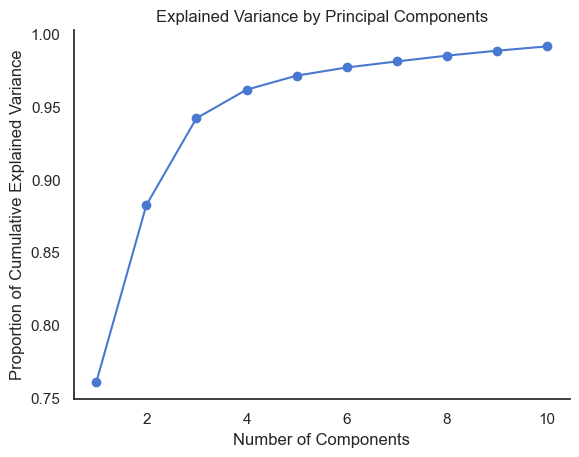

In [67]:
cumulative_variance = explained_variance.cumsum()
plt.plot(range(1, (len(cumulative_variance) + 1)), cumulative_variance, marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Cumulative Explained Variance")
plt.title("Explained Variance by Principal Components")
plt.show()

In [68]:
housing_feat_df = pd.concat([housing_feat_df, pca_df], axis=1)
housing_feat_df

,DAYS_REGISTRATION,FLAG_OWN_REALTY,NAME_HOUSING_TYPE,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,APARTMENTS_AVG,...,HOUSING_PC1,HOUSING_PC2,HOUSING_PC3,HOUSING_PC4,HOUSING_PC5,HOUSING_PC6,HOUSING_PC7,HOUSING_PC8,HOUSING_PC9,HOUSING_PC10
0,-10880.00000,Y,House / apartment,0,0,0,0,0,0,0.32983,...,0.72364,-0.80901,0.95200,-0.30223,-0.06199,0.06967,-0.13568,0.08716,-0.15173,0.17754
1,-5608.00000,Y,House / apartment,0,0,0,0,0,0,0.08270,...,1.06943,0.09146,-0.27093,-0.11968,-0.04559,0.03892,-0.01134,0.02232,0.02896,-0.01303
2,-901.00000,Y,House / apartment,0,0,0,0,0,0,0.00000,...,-1.01848,0.11932,0.01866,-0.00106,-0.00060,0.00014,-0.00003,0.00034,0.00019,0.00027
3,-429.00000,Y,House / apartment,0,0,0,0,1,1,0.00000,...,-1.01848,0.11932,0.01866,-0.00106,-0.00060,0.00014,-0.00003,0.00034,0.00019,0.00027
4,-9808.00000,Y,House / apartment,0,0,0,0,0,0,0.00000,...,-1.01848,0.11932,0.01866,-0.00106,-0.00060,0.00014,-0.00003,0.00034,0.00019,0.00027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196801,-5788.00000,Y,House / apartment,0,0,0,0,0,0,0.10211,...,1.06054,0.02059,-0.16838,-0.27488,-0.06198,0.09464,0.12145,-0.06268,0.00018,-0.08753
196802,-10432.00000,N,House / apartment,0,0,0,0,0,0,0.00000,...,-1.01848,0.11932,0.01866,-0.00106,-0.00060,0.00014,-0.00003,0.00034,0.00019,0.00027
196803,-3152.00000,Y,House / apartment,0,0,0,0,0,0,0.00000,...,-1.01848,0.11932,0.01866,-0.00106,-0.00060,0.00014,-0.00003,0.00034,0.00019,0.00027
196804,-1373.00000,Y,House / apartment,0,0,0,0,0,0,0.13806,...,0.54945,-0.85389,0.28495,0.19970,-0.18701,0.07327,-0.08596,0.04665,0.00254,-0.07098


For object features about housing:
- create an indicator column for missing values
- impute missing values with Unknown

In [69]:
for col in housing_object:
    housing_feat_df[col + "_MISSING"] = housing_feat_df[col].isna().astype(int)
housing_feat_df[housing_object] = housing_feat_df[housing_object].fillna("Unknown")

##### Feature Selection - Boruta

In [70]:
housing_feat_df_boruta, _ = boruta_feature_selection(
    housing_feat_df, y_train.values.ravel()
)
housing_feat_df_boruta

Iteration: 	1 / 40
Confirmed: 	0
Tentative: 	136
Rejected: 	0
Iteration: 	2 / 40
Confirmed: 	0
Tentative: 	136
Rejected: 	0
Iteration: 	3 / 40
Confirmed: 	0
Tentative: 	136
Rejected: 	0
Iteration: 	4 / 40
Confirmed: 	0
Tentative: 	136
Rejected: 	0
Iteration: 	5 / 40
Confirmed: 	0
Tentative: 	136
Rejected: 	0
Iteration: 	6 / 40
Confirmed: 	0
Tentative: 	136
Rejected: 	0
Iteration: 	7 / 40
Confirmed: 	0
Tentative: 	136
Rejected: 	0
Iteration: 	8 / 40
Confirmed: 	29
Tentative: 	18
Rejected: 	89
Iteration: 	9 / 40
Confirmed: 	29
Tentative: 	18
Rejected: 	89
Iteration: 	10 / 40
Confirmed: 	29
Tentative: 	18
Rejected: 	89
Iteration: 	11 / 40
Confirmed: 	29
Tentative: 	18
Rejected: 	89
Iteration: 	12 / 40
Confirmed: 	32
Tentative: 	12
Rejected: 	92
Iteration: 	13 / 40
Confirmed: 	32
Tentative: 	12
Rejected: 	92
Iteration: 	14 / 40
Confirmed: 	32
Tentative: 	12
Rejected: 	92
Iteration: 	15 / 40
Confirmed: 	32
Tentative: 	12
Rejected: 	92
Iteration: 	16 / 40
Confirmed: 	32
Tentative: 	8
Rejecte

,DAYS_REGISTRATION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,APARTMENTS_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,...,HOUSING_PC2,HOUSING_PC3,HOUSING_PC4,HOUSING_PC5,HOUSING_PC6,HOUSING_PC7,HOUSING_PC8,HOUSING_PC9,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_With parents
0,-10880.00000,0,0,0,0.32983,0.98389,0.36011,0.31030,0.33325,0.33081,...,-0.80901,0.95200,-0.30223,-0.06199,0.06967,-0.13568,0.08716,-0.15173,1.00000,0.00000
1,-5608.00000,0,0,0,0.08270,0.97559,0.00000,0.14661,0.16675,0.06439,...,0.09146,-0.27093,-0.11968,-0.04559,0.03892,-0.01134,0.02232,0.02896,1.00000,0.00000
2,-901.00000,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.11932,0.01866,-0.00106,-0.00060,0.00014,-0.00003,0.00034,0.00019,1.00000,0.00000
3,-429.00000,0,1,1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.11932,0.01866,-0.00106,-0.00060,0.00014,-0.00003,0.00034,0.00019,1.00000,0.00000
4,-9808.00000,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.11932,0.01866,-0.00106,-0.00060,0.00014,-0.00003,0.00034,0.00019,1.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196801,-5788.00000,0,0,0,0.10211,0.97314,0.00000,0.24146,0.16675,0.09723,...,0.02059,-0.16838,-0.27488,-0.06198,0.09464,0.12145,-0.06268,0.00018,1.00000,0.00000
196802,-10432.00000,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.11932,0.01866,-0.00106,-0.00060,0.00014,-0.00003,0.00034,0.00019,1.00000,0.00000
196803,-3152.00000,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.11932,0.01866,-0.00106,-0.00060,0.00014,-0.00003,0.00034,0.00019,1.00000,0.00000
196804,-1373.00000,0,0,0,0.13806,0.99463,0.12000,0.10339,0.36084,0.14502,...,-0.85389,0.28495,0.19970,-0.18701,0.07327,-0.08596,0.04665,0.00254,1.00000,0.00000


##### Correlation EDA

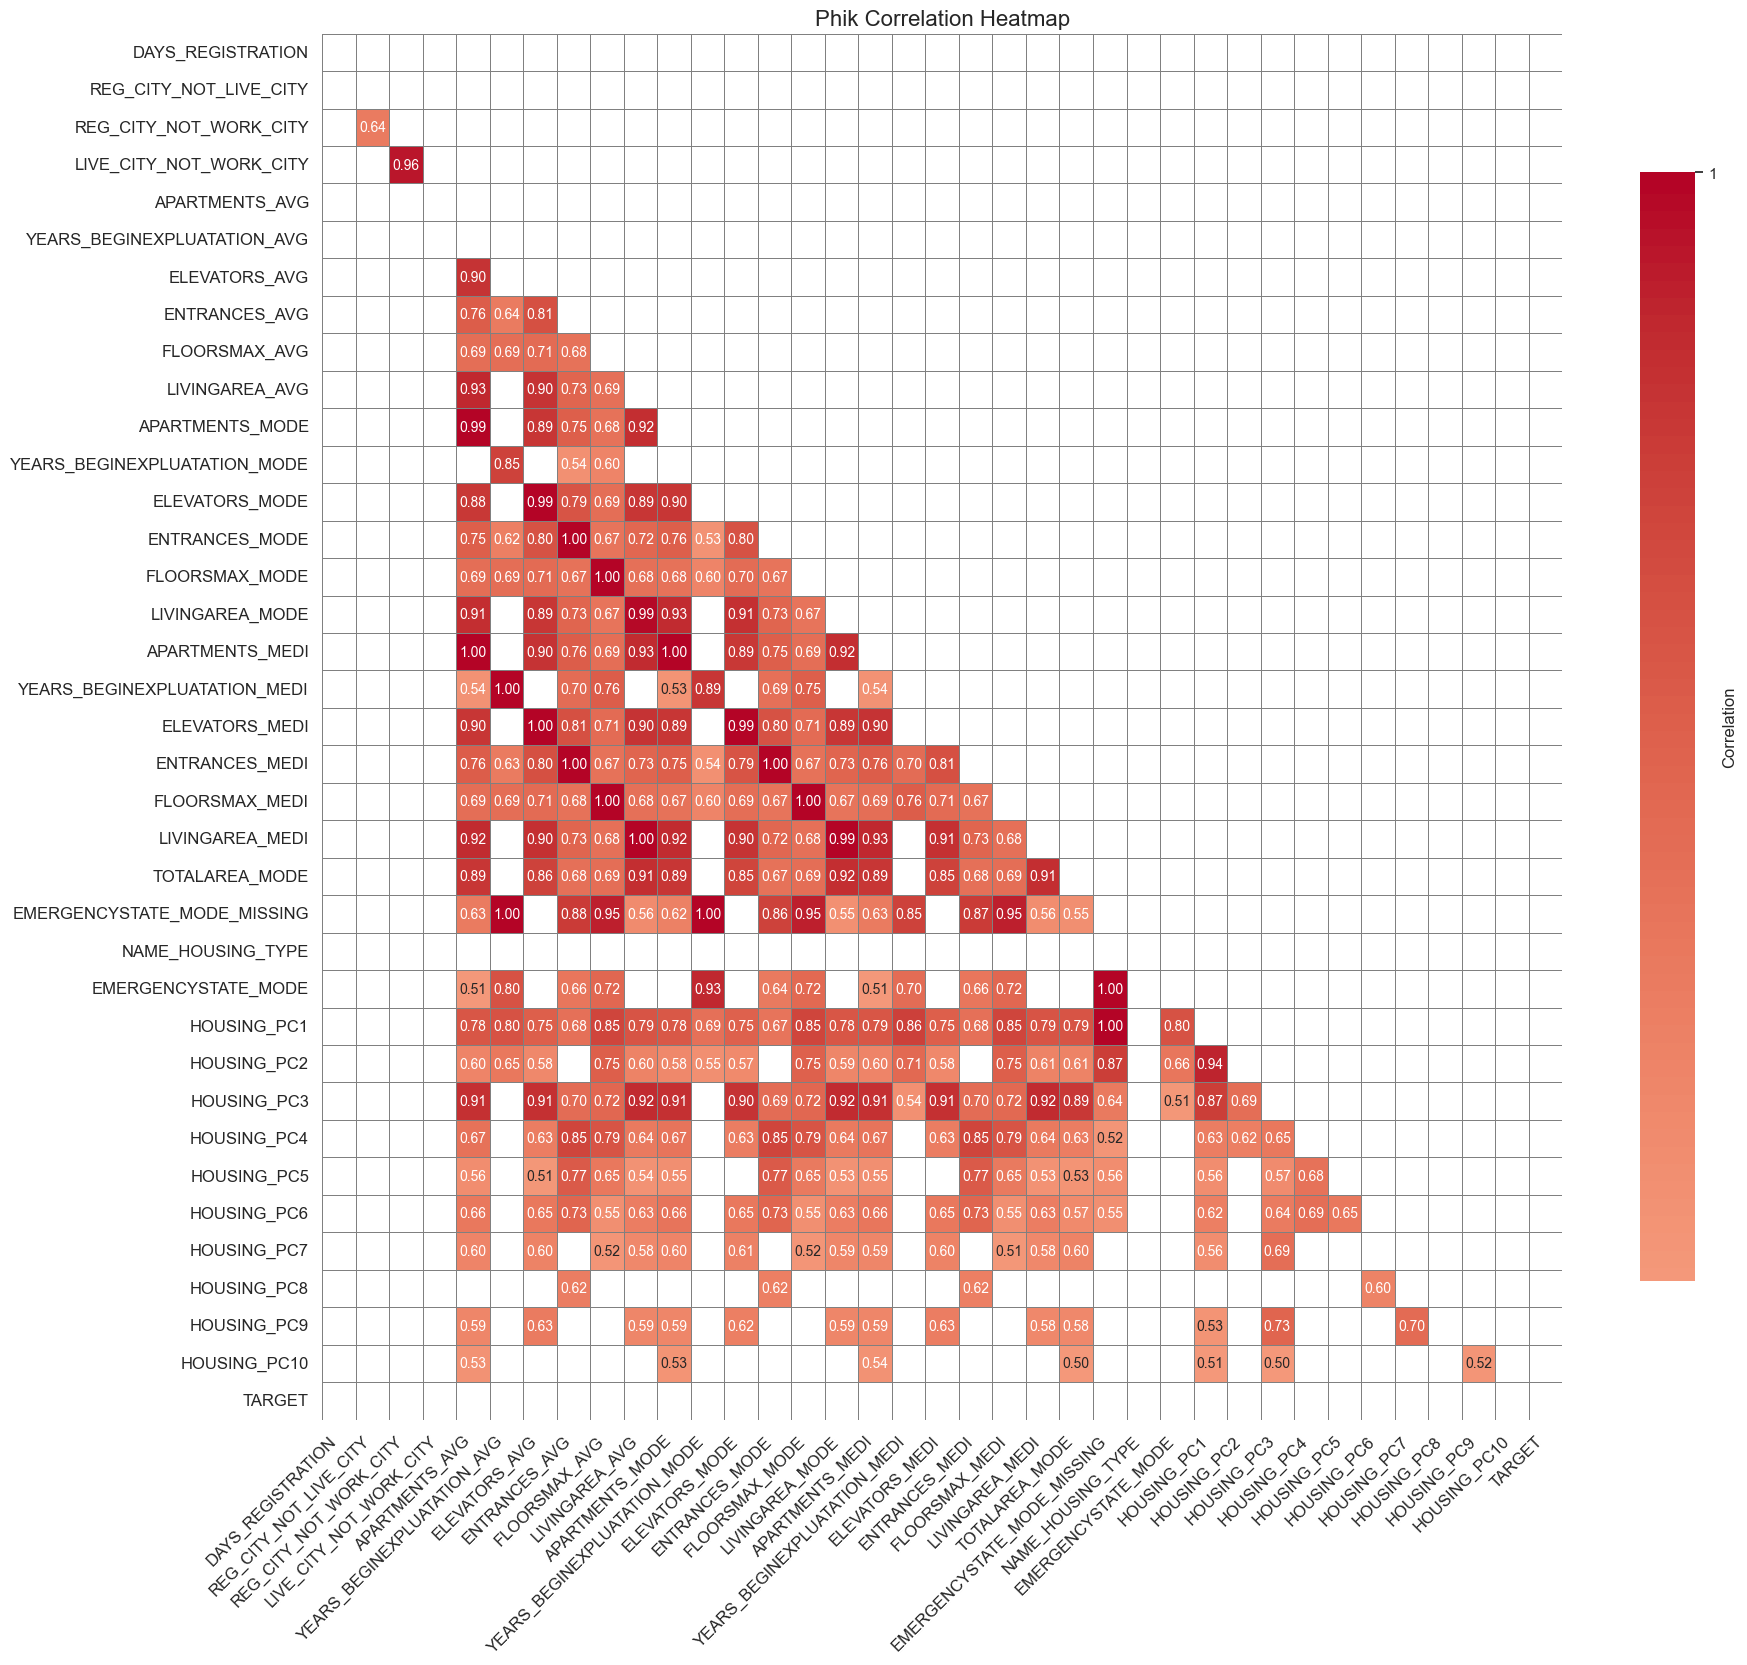

,Column 1,Column 2,Correlation
3,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,0.96337
7,APARTMENTS_AVG,ELEVATORS_AVG,0.89900
8,APARTMENTS_AVG,LIVINGAREA_AVG,0.92869
9,APARTMENTS_AVG,APARTMENTS_MODE,0.99218
10,APARTMENTS_AVG,ELEVATORS_MODE,0.88281
...,...,...,...
181,EMERGENCYSTATE_MODE_MISSING,HOUSING_PC1,0.99898
182,EMERGENCYSTATE_MODE_MISSING,HOUSING_PC2,0.87284
187,EMERGENCYSTATE_MODE,HOUSING_PC1,0.80082
195,HOUSING_PC1,HOUSING_PC2,0.93750


In [71]:
housing_feat_post_boruta = housing_feat_df[
    [
        "DAYS_REGISTRATION",
        "REG_CITY_NOT_LIVE_CITY",
        "REG_CITY_NOT_WORK_CITY",
        "LIVE_CITY_NOT_WORK_CITY",
        "APARTMENTS_AVG",
        "YEARS_BEGINEXPLUATATION_AVG",
        "ELEVATORS_AVG",
        "ENTRANCES_AVG",
        "FLOORSMAX_AVG",
        "LIVINGAREA_AVG",
        "APARTMENTS_MODE",
        "YEARS_BEGINEXPLUATATION_MODE",
        "ELEVATORS_MODE",
        "ENTRANCES_MODE",
        "FLOORSMAX_MODE",
        "LIVINGAREA_MODE",
        "APARTMENTS_MEDI",
        "YEARS_BEGINEXPLUATATION_MEDI",
        "ELEVATORS_MEDI",
        "ENTRANCES_MEDI",
        "FLOORSMAX_MEDI",
        "LIVINGAREA_MEDI",
        "TOTALAREA_MODE",
        "EMERGENCYSTATE_MODE_MISSING",
        "NAME_HOUSING_TYPE",
        "EMERGENCYSTATE_MODE",
        *list(pca_df.columns),
    ]
]
interval_cols = [
    "DAYS_REGISTRATION",
    "APARTMENTS_AVG",
    "YEARS_BEGINEXPLUATATION_AVG",
    "ELEVATORS_AVG",
    "ENTRANCES_AVG",
    "FLOORSMAX_AVG",
    "LIVINGAREA_AVG",
    "APARTMENTS_MODE",
    "YEARS_BEGINEXPLUATATION_MODE",
    "ELEVATORS_MODE",
    "ENTRANCES_MODE",
    "FLOORSMAX_MODE",
    "LIVINGAREA_MODE",
    "APARTMENTS_MEDI",
    "YEARS_BEGINEXPLUATATION_MEDI",
    "ELEVATORS_MEDI",
    "ENTRANCES_MEDI",
    "FLOORSMAX_MEDI",
    "LIVINGAREA_MEDI",
    "TOTALAREA_MODE",
    *list(pca_df.columns),
]
housing_phik = pd.concat([housing_feat_post_boruta, y_train], axis=1).phik_matrix(
    interval_cols=interval_cols
)
ax = plot_correlation_matrix(housing_phik, figsize=(20, 18), threshold=0.5)
correlation_threshold(housing_phik, threshold=0.8)

In [72]:
housing_phik["TARGET"].sort_values(ascending=False)

TARGET                         1.00000
HOUSING_PC5                    0.01001
HOUSING_PC9                    0.00882
ENTRANCES_MODE                 0.00758
ENTRANCES_AVG                  0.00678
LIVINGAREA_AVG                 0.00668
LIVINGAREA_MEDI                0.00668
ENTRANCES_MEDI                 0.00623
FLOORSMAX_MEDI                 0.00515
FLOORSMAX_MODE                 0.00494
APARTMENTS_AVG                 0.00493
LIVINGAREA_MODE                0.00457
HOUSING_PC2                    0.00424
REG_CITY_NOT_LIVE_CITY         0.00401
HOUSING_PC8                    0.00237
REG_CITY_NOT_WORK_CITY         0.00234
FLOORSMAX_AVG                  0.00215
APARTMENTS_MEDI                0.00109
TOTALAREA_MODE                 0.00051
LIVE_CITY_NOT_WORK_CITY        0.00000
DAYS_REGISTRATION              0.00000
YEARS_BEGINEXPLUATATION_MEDI   0.00000
ELEVATORS_MEDI                 0.00000
YEARS_BEGINEXPLUATATION_MODE   0.00000
ELEVATORS_AVG                  0.00000
YEARS_BEGINEXPLUATATION_A

__Features to Keep:__
- DAYS_REGISTRATION
- REG_CITY_NOT_LIVE_CITY
- REG_CITY_NOT_WORK_CITY
- NAME_HOUSING_TYPE
- HOUSING_PC{N}
- or the features that went into creating housing PCs, that will be a choice in later notebooks.

#### Income Info
Features related to the applicant's income and work.

In [73]:
income_feats = [
    "AMT_INCOME_TOTAL",
    "NAME_INCOME_TYPE",
    "DAYS_EMPLOYED",
    "OCCUPATION_TYPE",
    "ORGANIZATION_TYPE",
]

In [74]:
income_feat_df = X_train[income_feats].copy()
income_feat_df = income_feat_df.reset_index().drop(["index"], axis=1)
income_feat_df

,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,DAYS_EMPLOYED,OCCUPATION_TYPE,ORGANIZATION_TYPE
0,112500.00000,Working,-1832,Core staff,Self-employed
1,270000.00000,Commercial associate,-3050,Private service staff,Business Entity Type 3
2,112500.00000,Working,-5094,High skill tech staff,Government
3,292500.00000,Working,-319,Core staff,Self-employed
4,202500.00000,Working,-1232,Drivers,Business Entity Type 3
...,...,...,...,...,...
196801,225000.00000,Working,-629,Sales staff,Trade: type 1
196802,180000.00000,Working,-5796,Medicine staff,Agriculture
196803,180000.00000,Working,-3780,Core staff,Police
196804,135000.00000,Working,-9923,Managers,School


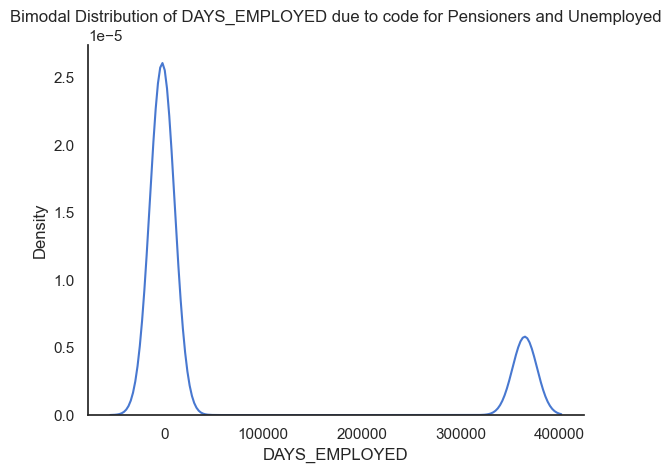

In [75]:
ax = sns.kdeplot(income_feat_df, x="DAYS_EMPLOYED")
plt.title(
    "Bimodal Distribution of DAYS_EMPLOYED due to code for Pensioners and Unemployed"
)
plt.show()

In [76]:
income_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196806 entries, 0 to 196805
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   AMT_INCOME_TOTAL   196806 non-null  float32
 1   NAME_INCOME_TYPE   196806 non-null  object 
 2   DAYS_EMPLOYED      196806 non-null  int32  
 3   OCCUPATION_TYPE    135134 non-null  object 
 4   ORGANIZATION_TYPE  196806 non-null  object 
dtypes: float32(1), int32(1), object(3)
memory usage: 6.0+ MB


__AMT_INCOME_TOTAL:__
_Income of the client_

__NAME_INCOME_TYPE:__
_Clients' income type_

__DAYS_EMPLOYED:__
_How many days before the application the person started current employment_

__OCCUPATION_TYPE:__
_What kind of occupation does the client have?_

__ORGANIZATION_TYPE:__
_Type of organization where client works_

##### Value Imputation

In [77]:
income_feat_df["DAYS_EMPLOYED"] = np.where(
    income_feat_df["NAME_INCOME_TYPE"].isin(["Pensioner", "Unemployed"]),
    0,
    income_feat_df["DAYS_EMPLOYED"],
)

In [78]:
income_feat_df["DAYS_EMPLOYED"].describe()

count   196806.00000
mean     -1962.33094
std       2316.63883
min     -17912.00000
25%      -2765.00000
50%      -1219.00000
75%       -292.00000
max          0.00000
Name: DAYS_EMPLOYED, dtype: float64

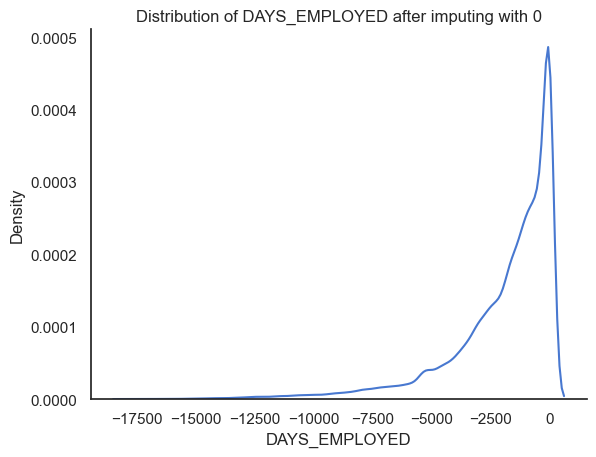

In [79]:
ax = sns.kdeplot(income_feat_df, x="DAYS_EMPLOYED")
plt.title("Distribution of DAYS_EMPLOYED after imputing with 0")
plt.show()

In [80]:
income_feat_df["OCCUPATION_TYPE"] = income_feat_df["OCCUPATION_TYPE"].fillna("UNKNOWN")

##### Feature Selection - Boruta

In [81]:
income_feat_df_boruta, _ = boruta_feature_selection(
    income_feat_df, y_train.values.ravel()
)
income_feat_df_boruta

Iteration: 	1 / 40
Confirmed: 	0
Tentative: 	87
Rejected: 	0
Iteration: 	2 / 40
Confirmed: 	0
Tentative: 	87
Rejected: 	0
Iteration: 	3 / 40
Confirmed: 	0
Tentative: 	87
Rejected: 	0
Iteration: 	4 / 40
Confirmed: 	0
Tentative: 	87
Rejected: 	0
Iteration: 	5 / 40
Confirmed: 	0
Tentative: 	87
Rejected: 	0
Iteration: 	6 / 40
Confirmed: 	0
Tentative: 	87
Rejected: 	0
Iteration: 	7 / 40
Confirmed: 	0
Tentative: 	87
Rejected: 	0
Iteration: 	8 / 40
Confirmed: 	16
Tentative: 	3
Rejected: 	68
Iteration: 	9 / 40
Confirmed: 	16
Tentative: 	3
Rejected: 	68
Iteration: 	10 / 40
Confirmed: 	16
Tentative: 	3
Rejected: 	68
Iteration: 	11 / 40
Confirmed: 	16
Tentative: 	3
Rejected: 	68
Iteration: 	12 / 40
Confirmed: 	16
Tentative: 	3
Rejected: 	68
Iteration: 	13 / 40
Confirmed: 	16
Tentative: 	3
Rejected: 	68
Iteration: 	14 / 40
Confirmed: 	16
Tentative: 	3
Rejected: 	68
Iteration: 	15 / 40
Confirmed: 	16
Tentative: 	3
Rejected: 	68
Iteration: 	16 / 40
Confirmed: 	16
Tentative: 	3
Rejected: 	68
Iteratio

,AMT_INCOME_TOTAL,DAYS_EMPLOYED,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_UNKNOWN,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_XNA
0,112500.00000,-1832,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
1,270000.00000,-3050,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
2,112500.00000,-5094,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,292500.00000,-319,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
4,202500.00000,-1232,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196801,225000.00000,-629,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
196802,180000.00000,-5796,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
196803,180000.00000,-3780,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
196804,135000.00000,-9923,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000


##### Correlation EDA

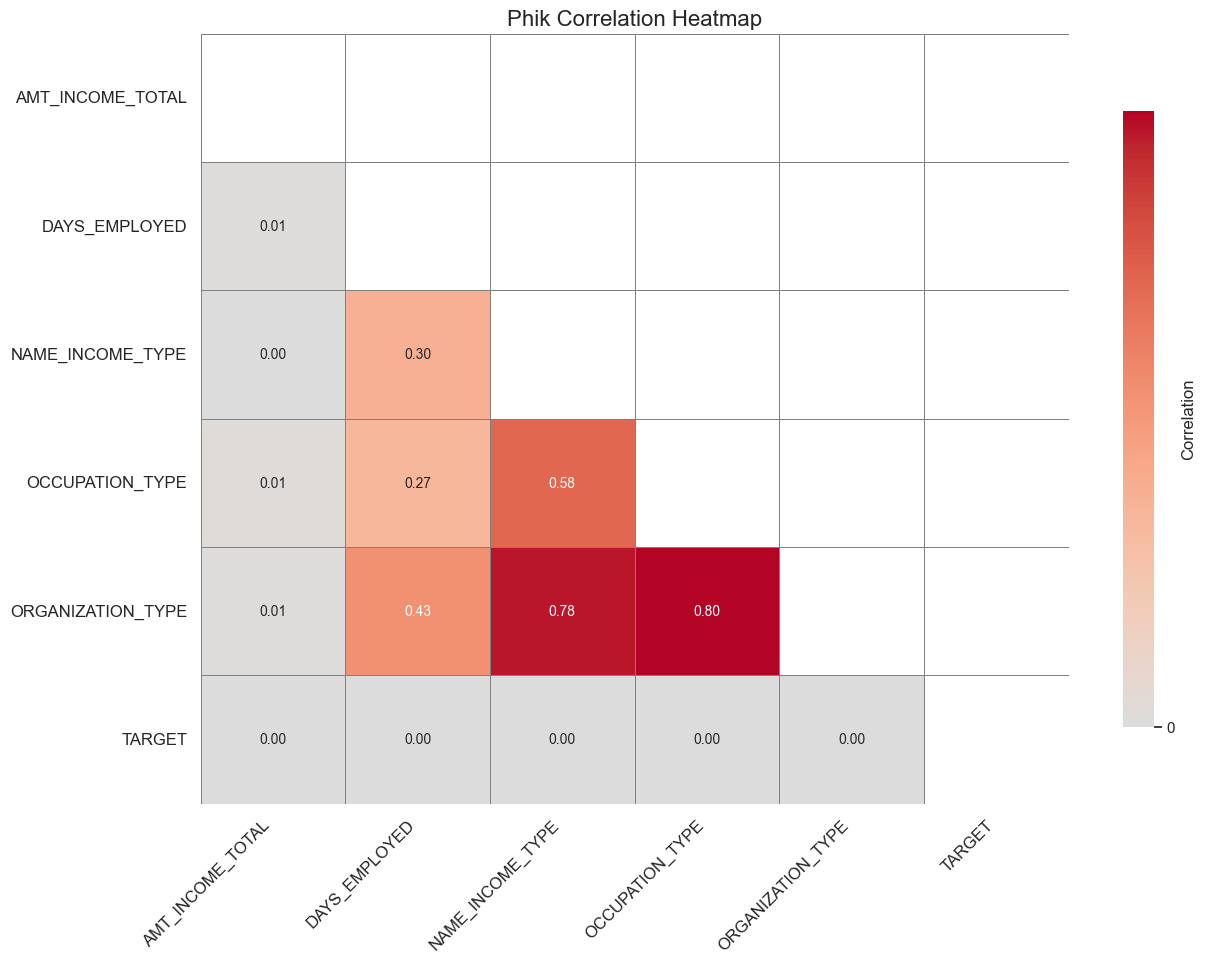

,Column 1,Column 2,Correlation
4,OCCUPATION_TYPE,ORGANIZATION_TYPE,0.80239


In [82]:
income_feat_post_boruta = income_feat_df[
    [
        "AMT_INCOME_TOTAL",
        "DAYS_EMPLOYED",
        "NAME_INCOME_TYPE",
        "OCCUPATION_TYPE",
        "ORGANIZATION_TYPE",
    ]
]
interval_cols = ["AMT_INCOME_TOTAL", "DAYS_EMPLOYED"]
income_phik = pd.concat([income_feat_post_boruta, y_train], axis=1).phik_matrix(
    interval_cols=interval_cols
)
ax = plot_correlation_matrix(income_phik)
correlation_threshold(income_phik, threshold=0.8)

Features to Keep:
- AMT_INCOME TOTAL 
- DAYS_EMPLOYED
- NAME_INCOME_TYPE
- OCCUPATION_TYPE
- ORGANIZATION_TYPE (note: correlated with OCCUPATION_TYPE and has many unique values)

#### Loan Info 
Information about the loan itself, such as the amount that it is for and the amount of the goods that it will be used for in the case of business.

In [83]:
loan_feats = ["NAME_CONTRACT_TYPE", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]

In [84]:
loan_feat_df = X_train[loan_feats].copy()
loan_feat_df = loan_feat_df.reset_index().drop(["index"], axis=1)
loan_feat_df

,NAME_CONTRACT_TYPE,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE
0,Cash loans,808650.00000,23773.50000,675000.00000
1,Cash loans,733315.50000,39199.50000,679500.00000
2,Cash loans,555273.00000,18040.50000,463500.00000
3,Cash loans,835380.00000,40320.00000,675000.00000
4,Cash loans,1724220.00000,50544.00000,1350000.00000
...,...,...,...,...
196801,Revolving loans,270000.00000,13500.00000,270000.00000
196802,Cash loans,225000.00000,11488.50000,225000.00000
196803,Cash loans,521280.00000,23089.50000,450000.00000
196804,Revolving loans,247500.00000,12375.00000,247500.00000


In [85]:
loan_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196806 entries, 0 to 196805
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   NAME_CONTRACT_TYPE  196806 non-null  object 
 1   AMT_CREDIT          196806 non-null  float32
 2   AMT_ANNUITY         196798 non-null  float32
 3   AMT_GOODS_PRICE     196640 non-null  float32
dtypes: float32(3), object(1)
memory usage: 3.8+ MB


__NAME_CONTRACT_TYPE:__
_Identification if loan is cash or revolving_

__AMT_CREDIT:__
_Credit amount of the loan_

__AMT_ANNUITY:__
_Loan annuity_

__AMT_GOODS_PRICE:__
_Goods price of good that client asked for (if applicable) on the previous application_

I will look at Credit and Annuity as fractions (or multiples) of income. 

##### Feature Engineering and Missing Value Imputation

In [86]:
loan_feat_income_df = pd.concat(
    [loan_feat_df, X_train["AMT_INCOME_TOTAL"].copy()], axis=1
)
loan_feat_df["CREDIT_ANNUITY_RATIO"] = (
    loan_feat_df["AMT_CREDIT"] / loan_feat_df["AMT_ANNUITY"]
)
loan_feat_df["CREDIT_BY_INCOME"] = (
    loan_feat_income_df["AMT_CREDIT"] / loan_feat_income_df["AMT_INCOME_TOTAL"]
)
loan_feat_df["ANNUITY_BY_INCOME"] = (
    loan_feat_income_df["AMT_ANNUITY"] / loan_feat_income_df["AMT_INCOME_TOTAL"]
)
loan_feat_df

,NAME_CONTRACT_TYPE,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CREDIT_ANNUITY_RATIO,CREDIT_BY_INCOME,ANNUITY_BY_INCOME
0,Cash loans,808650.00000,23773.50000,675000.00000,34.01476,3.99333,0.11740
1,Cash loans,733315.50000,39199.50000,679500.00000,18.70727,2.71598,0.14518
2,Cash loans,555273.00000,18040.50000,463500.00000,30.77925,8.22627,0.26727
3,Cash loans,835380.00000,40320.00000,675000.00000,20.71875,NaN,NaN
4,Cash loans,1724220.00000,50544.00000,1350000.00000,34.11325,NaN,NaN
...,...,...,...,...,...,...,...
196801,Revolving loans,270000.00000,13500.00000,270000.00000,20.00000,3.00000,0.15000
196802,Cash loans,225000.00000,11488.50000,225000.00000,19.58480,2.32180,0.11855
196803,Cash loans,521280.00000,23089.50000,450000.00000,22.57650,5.03652,0.22309
196804,Revolving loans,247500.00000,12375.00000,247500.00000,20.00000,2.75000,0.13750


In [87]:
loan_feat_df["AMT_ANNUITY_MISSING"] = loan_feat_df["AMT_ANNUITY"].isna().astype(int)
loan_feat_df["AMT_GOODS_PRICE_MISSING"] = (
    loan_feat_df["AMT_GOODS_PRICE"].isna().astype(int)
)
loan_feat_df = loan_feat_df.fillna(0)

##### Feature Selection - Boruta

In [88]:
loan_feat_df_boruta, _ = boruta_feature_selection(loan_feat_df, y_train.values.ravel())
loan_feat_df_boruta

Iteration: 	1 / 40
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 40
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 40
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 40
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 40
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 40
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 40
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 40
Confirmed: 	8
Tentative: 	0
Rejected: 	2


BorutaPy finished running.

Iteration: 	9 / 40
Confirmed: 	8
Tentative: 	0
Rejected: 	2


,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CREDIT_ANNUITY_RATIO,CREDIT_BY_INCOME,ANNUITY_BY_INCOME,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans
0,808650.00000,23773.50000,675000.00000,34.01476,3.99333,0.11740,1.00000,0.00000
1,733315.50000,39199.50000,679500.00000,18.70727,2.71598,0.14518,1.00000,0.00000
2,555273.00000,18040.50000,463500.00000,30.77925,8.22627,0.26727,1.00000,0.00000
3,835380.00000,40320.00000,675000.00000,20.71875,0.00000,0.00000,1.00000,0.00000
4,1724220.00000,50544.00000,1350000.00000,34.11325,0.00000,0.00000,1.00000,0.00000
...,...,...,...,...,...,...,...,...
196801,270000.00000,13500.00000,270000.00000,20.00000,3.00000,0.15000,0.00000,1.00000
196802,225000.00000,11488.50000,225000.00000,19.58480,2.32180,0.11855,1.00000,0.00000
196803,521280.00000,23089.50000,450000.00000,22.57650,5.03652,0.22309,1.00000,0.00000
196804,247500.00000,12375.00000,247500.00000,20.00000,2.75000,0.13750,0.00000,1.00000


##### Correlation EDA

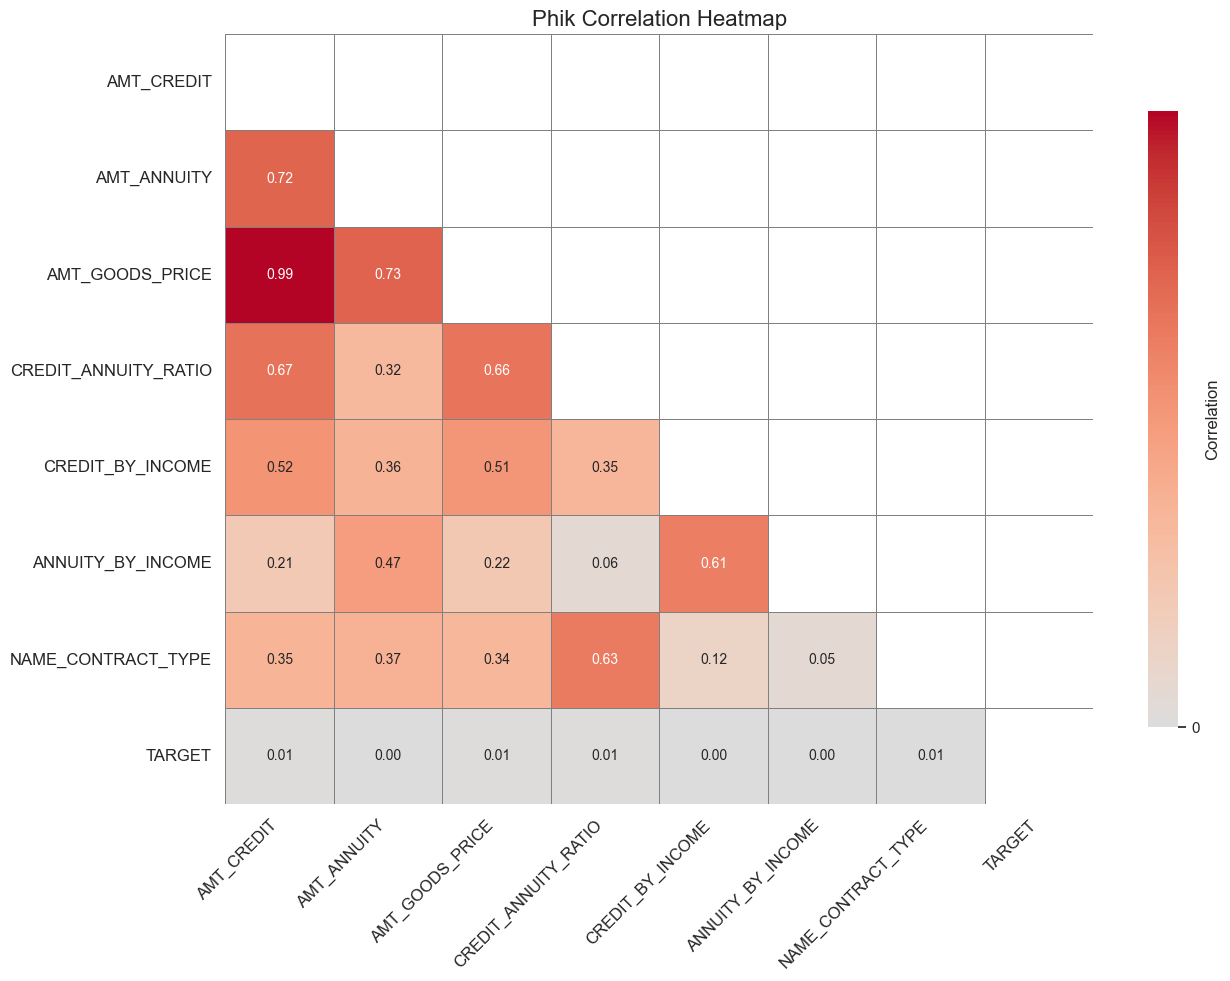

,Column 1,Column 2,Correlation
1,AMT_CREDIT,AMT_GOODS_PRICE,0.98503


In [89]:
loan_feat_post_boruta = loan_feat_df[
    [
        "AMT_CREDIT",
        "AMT_ANNUITY",
        "AMT_GOODS_PRICE",
        "CREDIT_ANNUITY_RATIO",
        "CREDIT_BY_INCOME",
        "ANNUITY_BY_INCOME",
        "NAME_CONTRACT_TYPE",
    ]
]
interval_cols = [
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "CREDIT_ANNUITY_RATIO",
    "ANNUITY_BY_INCOME",
    "CREDIT_BY_INCOME",
]
loan_phik = pd.concat([loan_feat_post_boruta, y_train], axis=1).phik_matrix(
    interval_cols=interval_cols
)
ax = plot_correlation_matrix(loan_phik)
correlation_threshold(loan_phik, threshold=0.8)

In [90]:
loan_phik["TARGET"].sort_values(ascending=False)

TARGET                 1.00000
AMT_GOODS_PRICE        0.01100
AMT_CREDIT             0.00993
CREDIT_ANNUITY_RATIO   0.00929
NAME_CONTRACT_TYPE     0.00542
AMT_ANNUITY            0.00332
ANNUITY_BY_INCOME      0.00000
CREDIT_BY_INCOME       0.00000
Name: TARGET, dtype: float64

Features to Keep: 
- AMT_CREDIT
- AMT_ANNUITY
- AMT_GOODS_PRICE
- CREDIT_ANNUITY_RATIO
- CREDIT_BY_INCOME
- ANNUITY_BY_INCOME
- NAME_CONTRACT_TYPE 

# Notebook Summary

- One good way to shrink the feature space for thinking about it was to consider sub-categories that made sense to me. 
- Information from other financial institutions appears to be the most informative. 
- There are many more features about housing than anything else
- There are correlated features that may produce issues for linear models that need to be considered. 
- Most missing values can be imputed with 0 and "unknown", although indicator columns do not appear to be useful (at least in the context of Boruta/Random Forest models). 